In [1]:
# Pre-COVID vs Post-COVID Market Analysis Notebook

## Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pickle
import joblib
import warnings
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, ElasticNet, LogisticRegression
from xgboost import XGBRegressor, XGBClassifier

# Suppress warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

In [2]:
## Cell 2: Load Datasets
# Load the datasets
nifty_df = pd.read_csv('/Users/priyeshgupta/sandbox/strategy-data-analysis/nifty-3weeks-expiry/data/NSE_NIFTY_2014.csv')
analysis_df = pd.read_csv('/Users/priyeshgupta/sandbox/strategy-data-analysis/nifty-3weeks-expiry/data/nifty_2014_analysis_results.csv')
vix_df = pd.read_csv('/Users/priyeshgupta/sandbox/strategy-data-analysis/nifty-3weeks-expiry/data/NSE_INDIAVIX_2014.csv')

# Display basic information about the datasets
print("Nifty DataFrame - Shape:", nifty_df.shape)
print("Analysis DataFrame - Shape:", analysis_df.shape)
print("VIX DataFrame - Shape:", vix_df.shape)

# Display the first few rows of each DataFrame
print("\nNifty DataFrame - Head:")
display(nifty_df.head())

print("\nAnalysis DataFrame - Head:")
display(analysis_df.head())

print("\nVIX DataFrame - Head:")
display(vix_df.head())

Nifty DataFrame - Shape: (18285, 7)
Analysis DataFrame - Shape: (518, 21)
VIX DataFrame - Shape: (18155, 5)

Nifty DataFrame - Head:


,time,open,high,low,close,Volume,Volume MA
0,2014-08-12T10:15:00+05:30,7671.25,7673.95,7657.50,7669.9,0,0.0
1,2014-08-12T11:15:00+05:30,7670.35,7672.65,7657.10,7664.7,0,0.0
2,2014-08-12T12:15:00+05:30,7664.65,7669.30,7654.80,7663.9,0,0.0
3,2014-08-12T13:15:00+05:30,7664.05,7676.25,7661.30,7675.7,0,0.0
4,2014-08-12T14:15:00+05:30,7675.55,7730.70,7672.45,7723.7,0,0.0



Analysis DataFrame - Head:


,monday_date,monday_day,monday_open,monday_low,monday_high,monday_close,monday_volume,expiry_date,expiry_day,expiry_open,expiry_low,expiry_high,expiry_close,expiry_volume,3_week_high,3_week_low,monday_close_minus_expiry_close,3_week_high_minus_monday_close,3_week_low_minus_monday_close,3_week_high_minus_thursday_close,3_week_low_minus_thursday_close
0,2014-08-18,Monday,7788.40,7779.20,7826.15,7822.95,0,2014-09-04,Thursday,8114.25,8081.00,8114.80,8089.00,0,8121.65,7779.20,-266.05,298.70,-43.75,32.65,-309.80
1,2014-08-25,Monday,7934.60,7927.75,7957.70,7940.55,0,2014-09-11,Thursday,8118.65,8096.25,8127.95,8114.75,0,8174.55,7871.65,-174.20,234.00,-68.90,59.80,-243.10
2,2014-09-01,Monday,7994.70,7984.00,8022.70,8019.80,0,2014-09-18,Thursday,7958.55,7939.70,8051.35,8037.00,0,8174.55,7936.95,-17.20,154.75,-82.85,137.55,-100.05
3,2014-09-08,Monday,8133.45,8126.15,8146.70,8146.20,0,2014-09-25,Thursday,8013.55,7980.70,8019.30,7990.05,0,8174.55,7936.95,156.15,28.35,-209.25,184.50,-53.10
4,2014-09-15,Monday,8077.30,8030.00,8077.30,8046.30,0,2014-10-01,Wednesday,7970.00,7948.40,7977.50,7962.40,0,8159.75,7884.85,83.90,113.45,-161.45,197.35,-77.55



VIX DataFrame - Head:


,datetime,open,high,low,close
0,2014-09-09T09:15:00+05:30,12.7925,13.0075,11.0125,12.8700
1,2014-09-09T10:15:00+05:30,12.8650,13.0100,12.8300,12.9700
2,2014-09-09T11:15:00+05:30,12.9775,13.0425,12.8825,12.9275
3,2014-09-09T12:15:00+05:30,12.9325,12.9650,12.7700,12.9175
4,2014-09-09T13:15:00+05:30,12.9200,13.0050,12.8075,12.8550


In [3]:
## Cell 3: Data Preprocessing
# Convert date columns to datetime
nifty_df['time'] = pd.to_datetime(nifty_df['time'])
analysis_df['monday_date'] = pd.to_datetime(analysis_df['monday_date'])
analysis_df['expiry_date'] = pd.to_datetime(analysis_df['expiry_date'])
vix_df['datetime'] = pd.to_datetime(vix_df['datetime'])

# Check for missing values
print("\nMissing values in Nifty DataFrame:", nifty_df.isnull().sum().sum())
print("Missing values in Analysis DataFrame:", analysis_df.isnull().sum().sum())
print("Missing values in VIX DataFrame:", vix_df.isnull().sum().sum())

# Handle missing values
analysis_df = analysis_df.fillna(0)
# vix_df = vix_df.dropna()

# Create a date column from datetime in vix_df for merging
vix_df['date'] = vix_df['datetime'].dt.date
vix_df['date'] = pd.to_datetime(vix_df['date'])

# Aggregate VIX data by date (taking the closing value of each day)
vix_daily = vix_df.groupby('date')['close'].last().reset_index()
vix_daily.rename(columns={'close': 'vix_close'}, inplace=True)


Missing values in Nifty DataFrame: 0
Missing values in Analysis DataFrame: 0
Missing values in VIX DataFrame: 0


In [4]:
## Cell 4: Feature Engineering
# Merge VIX data with analysis_df
analysis_with_vix = pd.merge(analysis_df, vix_daily, left_on='monday_date', right_on='date', how='left')
analysis_with_vix.drop('date', axis=1, inplace=True)

# Calculate range percentages
analysis_with_vix['range_percentage'] = ((analysis_with_vix['3_week_high'] - analysis_with_vix['3_week_low']) / analysis_with_vix['monday_close']) * 100
analysis_with_vix['high_range_percentage'] = ((analysis_with_vix['3_week_high'] - analysis_with_vix['monday_close']) / analysis_with_vix['monday_close']) * 100
analysis_with_vix['low_range_percentage'] = ((analysis_with_vix['3_week_low'] - analysis_with_vix['monday_close']) / analysis_with_vix['monday_close']) * 100

# Extract time-based features
analysis_with_vix['month'] = analysis_with_vix['monday_date'].dt.month
analysis_with_vix['week_of_year'] = analysis_with_vix['monday_date'].dt.isocalendar().week
analysis_with_vix['quarter'] = analysis_with_vix['monday_date'].dt.quarter

# Calculate price momentum (last 1, 2, 3 weeks change)
analysis_with_vix['monday_open_close_diff'] = analysis_with_vix['monday_close'] - analysis_with_vix['monday_open']
analysis_with_vix['monday_high_low_diff'] = analysis_with_vix['monday_high'] - analysis_with_vix['monday_low']
analysis_with_vix['expiry_open_close_diff'] = analysis_with_vix['expiry_close'] - analysis_with_vix['expiry_open']
analysis_with_vix['expiry_high_low_diff'] = analysis_with_vix['expiry_high'] - analysis_with_vix['expiry_low']

# Add volatility features
analysis_with_vix['monday_volatility'] = (analysis_with_vix['monday_high'] - analysis_with_vix['monday_low']) / analysis_with_vix['monday_open'] * 100
analysis_with_vix['expiry_volatility'] = (analysis_with_vix['expiry_high'] - analysis_with_vix['expiry_low']) / analysis_with_vix['expiry_open'] * 100

# Calculate historical volatility using rolling window (4 weeks)
analysis_with_vix['historical_volatility'] = analysis_with_vix['range_percentage'].rolling(window=4).std().fillna(0)

# Drop rows with NaN values after feature engineering
analysis_with_vix = analysis_with_vix.dropna()

In [5]:
## Cell 5: Split Data into Pre-COVID and Post-COVID Periods
# Define COVID split date (March 2020)
covid_split_date = pd.to_datetime('2020-02-28')

# Create pre-COVID and post-COVID dataframes
pre_covid_df = analysis_with_vix[analysis_with_vix['monday_date'] <= covid_split_date].copy()
post_covid_df = analysis_with_vix[analysis_with_vix['monday_date'] > pd.to_datetime('2020-08-01')].copy()

print(f"\nPre-COVID data points: {len(pre_covid_df)}")
print(f"Post-COVID data points: {len(post_covid_df)}")


Pre-COVID data points: 266
Post-COVID data points: 227


In [6]:
pre_covid_df

,monday_date,monday_day,monday_open,monday_low,monday_high,monday_close,monday_volume,expiry_date,expiry_day,expiry_open,expiry_low,expiry_high,expiry_close,expiry_volume,3_week_high,3_week_low,monday_close_minus_expiry_close,3_week_high_minus_monday_close,3_week_low_minus_monday_close,3_week_high_minus_thursday_close,3_week_low_minus_thursday_close,vix_close,range_percentage,high_range_percentage,low_range_percentage,month,week_of_year,quarter,monday_open_close_diff,monday_high_low_diff,expiry_open_close_diff,expiry_high_low_diff,monday_volatility,expiry_volatility,historical_volatility
4,2014-09-15,Monday,8077.30,8030.00,8077.30,8046.30,0,2014-10-01,Wednesday,7970.00,7948.40,7977.50,7962.40,0,8159.75,7884.85,83.90,113.45,-161.45,197.35,-77.55,13.1900,3.416477,1.409965,-2.006512,9,38,3,-31.00,47.30,-7.60,29.10,0.585592,0.365119,0.423118
5,2014-09-22,Monday,8086.95,8064.80,8088.50,8080.70,0,2014-10-09,Thursday,7900.90,7900.85,7935.35,7932.05,0,8159.75,7826.70,148.65,79.05,-254.00,227.70,-105.35,11.7200,4.121549,0.978257,-3.143292,9,39,3,-6.25,23.70,31.15,34.50,0.293065,0.436659,0.558990
6,2014-09-29,Monday,7978.15,7937.80,7987.60,7978.00,0,2014-10-16,Thursday,7839.85,7836.45,7893.90,7856.35,0,7987.60,7796.00,121.65,9.60,-182.00,131.25,-60.35,13.1325,2.401604,0.120331,-2.281274,9,40,3,-0.15,49.80,16.50,57.45,0.624205,0.732795,0.733262
7,2014-10-13,Monday,7829.45,7796.00,7835.10,7817.20,0,2014-10-30,Thursday,8091.00,8088.55,8121.95,8117.10,0,8121.95,7729.65,-299.90,304.75,-87.55,4.85,-387.45,14.4150,5.018421,3.898455,-1.119966,10,42,4,-12.25,39.10,26.10,33.40,0.499397,0.412804,1.106934
8,2014-10-20,Monday,7897.55,7872.20,7898.80,7884.25,0,2014-11-05,Wednesday,8351.25,8326.10,8363.95,8346.15,0,8363.95,7872.20,-461.90,479.70,-12.05,17.80,-473.95,14.0550,6.237118,6.084282,-0.152836,10,43,4,-13.30,26.60,-5.10,37.85,0.336813,0.453226,1.614578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,2020-01-27,Monday,12198.10,12154.60,12213.40,12202.60,0,2020-02-13,Thursday,12225.65,12156.15,12225.65,12166.90,0,12225.65,11614.50,35.70,23.05,-588.10,58.75,-552.40,17.2750,5.008359,0.188894,-4.819465,1,5,1,4.50,58.80,-58.75,69.50,0.482042,0.568477,1.518089
267,2020-02-03,Monday,11642.95,11614.50,11721.20,11709.60,0,2020-02-20,Thursday,12109.05,12092.80,12131.95,12113.65,0,12246.70,11614.50,-404.05,537.10,-95.10,133.05,-499.15,15.5300,5.398989,4.586835,-0.812154,2,6,1,66.65,106.70,4.60,39.15,0.916434,0.323312,1.493702
268,2020-02-10,Monday,12103.55,12016.20,12103.55,12023.90,0,2020-02-27,Thursday,11663.85,11549.65,11663.85,11558.70,0,12246.70,11549.65,465.20,222.80,-474.25,688.00,-9.05,14.1625,5.797204,1.852976,-3.944228,2,7,1,-79.65,87.35,-105.15,114.20,0.721689,0.979094,0.683607
269,2020-02-17,Monday,12133.65,12073.65,12159.60,12103.30,0,2020-03-05,Thursday,11307.40,11249.45,11339.95,11272.60,0,12159.60,11215.95,830.70,56.30,-887.35,887.00,-56.65,14.5175,7.796634,0.465162,-7.331472,2,8,1,-30.35,85.95,-34.80,90.50,0.708361,0.800361,1.240106


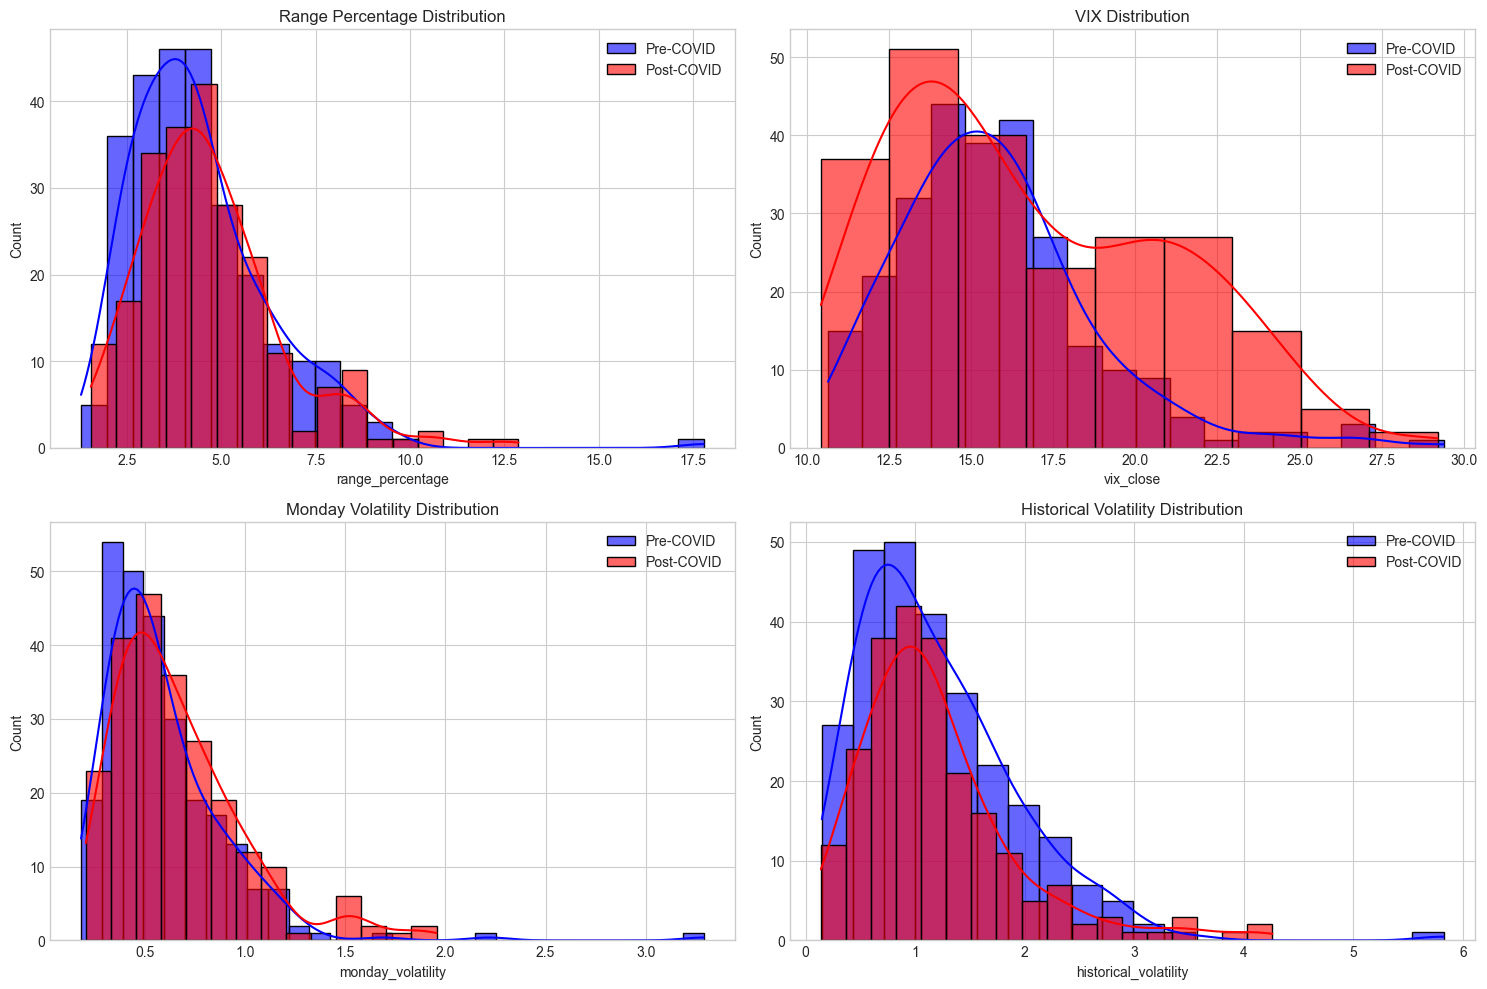

In [7]:
## Cell 6: Visualize Data Distribution Between Periods
plt.figure(figsize=(15, 10))

# Range Percentage Distribution
plt.subplot(2, 2, 1)
sns.histplot(pre_covid_df['range_percentage'], kde=True, color='blue', alpha=0.6, label='Pre-COVID')
sns.histplot(post_covid_df['range_percentage'], kde=True, color='red', alpha=0.6, label='Post-COVID')
plt.title('Range Percentage Distribution')
plt.legend()

# VIX Distribution
plt.subplot(2, 2, 2)
sns.histplot(pre_covid_df['vix_close'], kde=True, color='blue', alpha=0.6, label='Pre-COVID')
sns.histplot(post_covid_df['vix_close'], kde=True, color='red', alpha=0.6, label='Post-COVID')
plt.title('VIX Distribution')
plt.legend()

# Volatility Distribution
plt.subplot(2, 2, 3)
sns.histplot(pre_covid_df['monday_volatility'], kde=True, color='blue', alpha=0.6, label='Pre-COVID')
sns.histplot(post_covid_df['monday_volatility'], kde=True, color='red', alpha=0.6, label='Post-COVID')
plt.title('Monday Volatility Distribution')
plt.legend()

# Historical Volatility Distribution
plt.subplot(2, 2, 4)
sns.histplot(pre_covid_df['historical_volatility'], kde=True, color='blue', alpha=0.6, label='Pre-COVID')
sns.histplot(post_covid_df['historical_volatility'], kde=True, color='red', alpha=0.6, label='Post-COVID')
plt.title('Historical Volatility Distribution')
plt.legend()

plt.tight_layout()
plt.show()

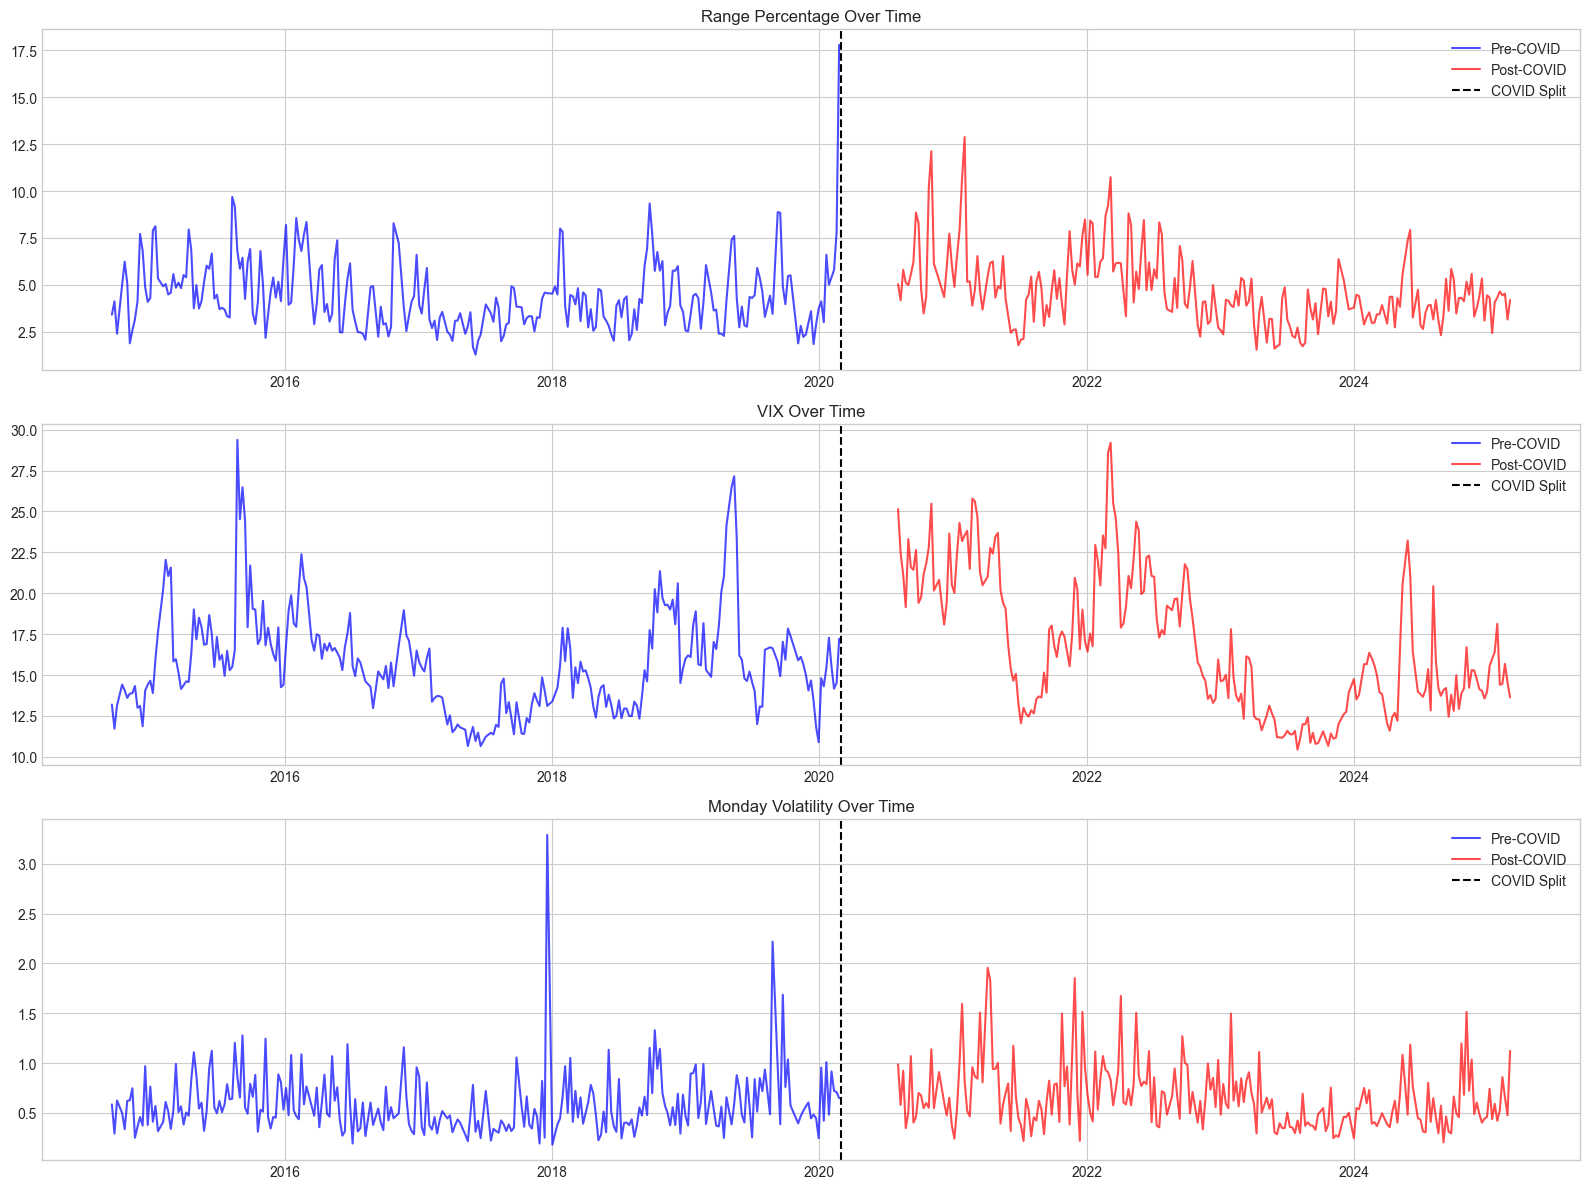

In [8]:
## Cell 7: Time Series Visualization of Key Metrics
plt.figure(figsize=(16, 12))

# Plot Range Percentage Over Time
plt.subplot(3, 1, 1)
plt.plot(pre_covid_df['monday_date'], pre_covid_df['range_percentage'], color='blue', alpha=0.7, label='Pre-COVID')
plt.plot(post_covid_df['monday_date'], post_covid_df['range_percentage'], color='red', alpha=0.7, label='Post-COVID')
plt.axvline(x=covid_split_date, color='black', linestyle='--', label='COVID Split')
plt.title('Range Percentage Over Time')
plt.legend()

# Plot VIX Over Time
plt.subplot(3, 1, 2)
plt.plot(pre_covid_df['monday_date'], pre_covid_df['vix_close'], color='blue', alpha=0.7, label='Pre-COVID')
plt.plot(post_covid_df['monday_date'], post_covid_df['vix_close'], color='red', alpha=0.7, label='Post-COVID')
plt.axvline(x=covid_split_date, color='black', linestyle='--', label='COVID Split')
plt.title('VIX Over Time')
plt.legend()

# Plot Monday Volatility Over Time
plt.subplot(3, 1, 3)
plt.plot(pre_covid_df['monday_date'], pre_covid_df['monday_volatility'], color='blue', alpha=0.7, label='Pre-COVID')
plt.plot(post_covid_df['monday_date'], post_covid_df['monday_volatility'], color='red', alpha=0.7, label='Post-COVID')
plt.axvline(x=covid_split_date, color='black', linestyle='--', label='COVID Split')
plt.title('Monday Volatility Over Time')
plt.legend()

plt.tight_layout()
plt.show()

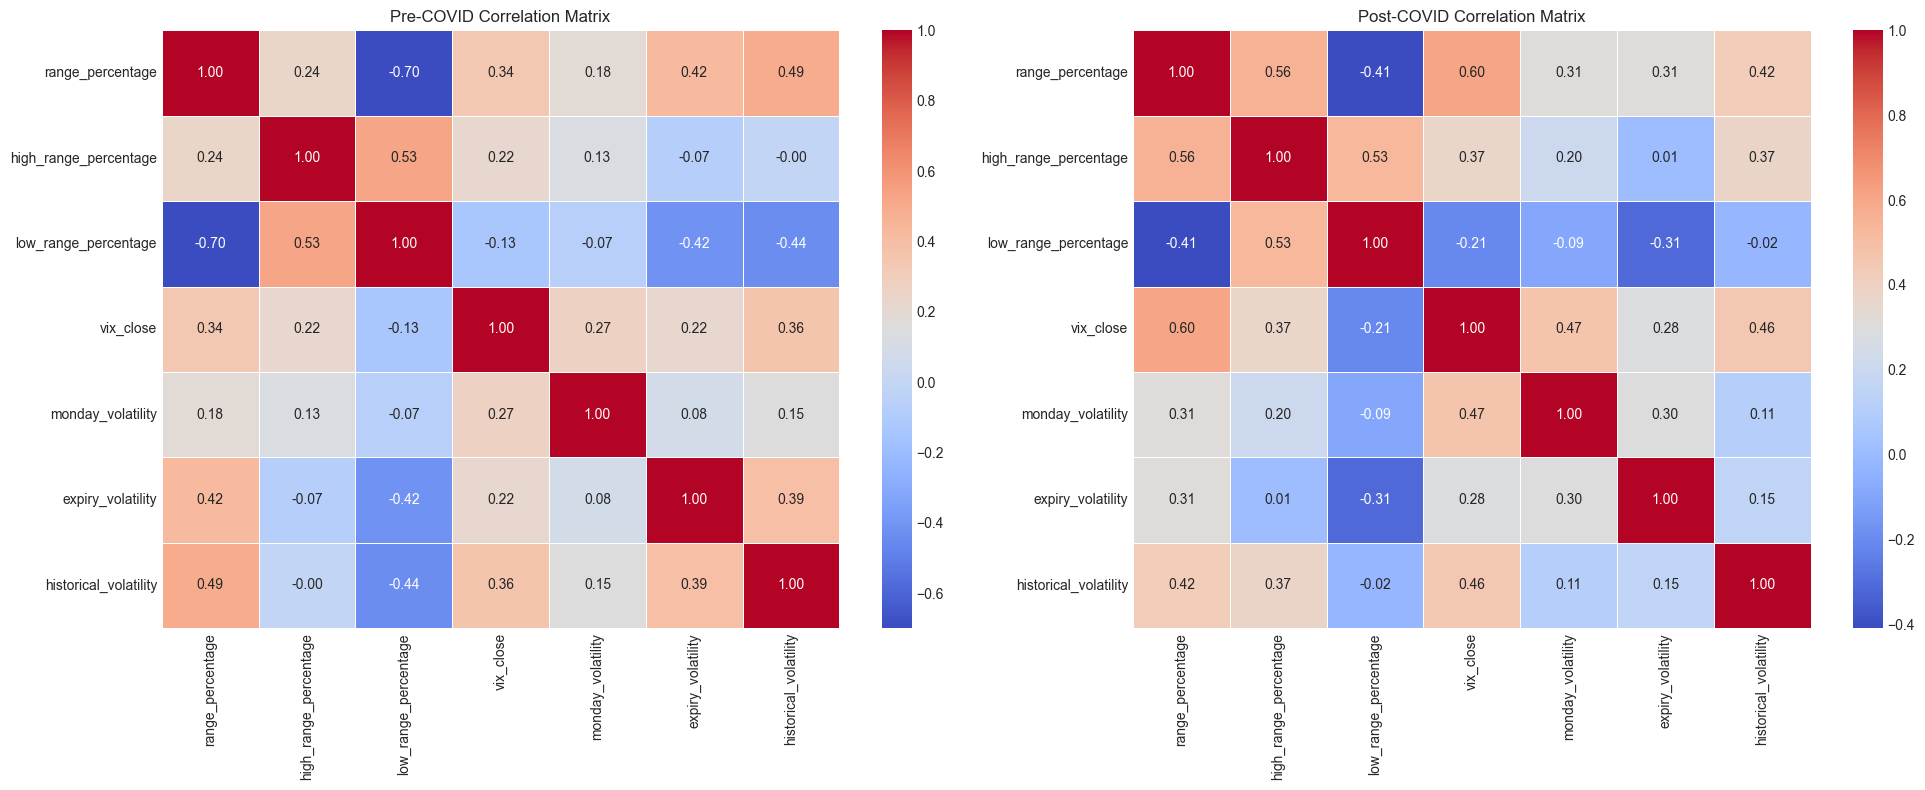

In [9]:
## Cell 8: Correlation Analysis - Pre vs Post COVID
plt.figure(figsize=(20, 8))

# Pre-COVID Correlation
plt.subplot(1, 2, 1)
corr_features_pre = ['range_percentage', 'high_range_percentage', 'low_range_percentage', 
                     'vix_close', 'monday_volatility', 'expiry_volatility', 'historical_volatility']
corr_pre = pre_covid_df[corr_features_pre].corr()
sns.heatmap(corr_pre, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pre-COVID Correlation Matrix')

# Post-COVID Correlation
plt.subplot(1, 2, 2)
corr_post = post_covid_df[corr_features_pre].corr()
sns.heatmap(corr_post, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Post-COVID Correlation Matrix')

plt.tight_layout()
plt.show()

In [10]:
## Cell 9: Define Target Variables and Features for Both Periods
# Features to use for modeling
feature_columns = [
    'monday_open', 'monday_low', 'monday_high', 'monday_close',
    'expiry_open', 'expiry_low', 'expiry_high', 'expiry_close',
    'vix_close', 'monday_open_close_diff', 'monday_high_low_diff',
    'expiry_open_close_diff', 'expiry_high_low_diff',
    'monday_volatility', 'expiry_volatility', 'historical_volatility',
    'month', 'week_of_year', 'quarter'
]

# Target variables
target_reg = 'range_percentage'
target_high_reg = 'high_range_percentage'
target_low_reg = 'low_range_percentage'

# Create binary target for classification (is the range percentage above average?)
pre_covid_mean_range = pre_covid_df[target_reg].mean()
post_covid_mean_range = post_covid_df[target_reg].mean()

pre_covid_df['above_avg_range'] = (pre_covid_df[target_reg] > pre_covid_mean_range).astype(int)
post_covid_df['above_avg_range'] = (post_covid_df[target_reg] > post_covid_mean_range).astype(int)

# Create direction target (1 if closing price is higher than opening, 0 otherwise)
pre_covid_df['price_direction'] = (pre_covid_df['3_week_high'] > pre_covid_df['monday_close']).astype(int)
post_covid_df['price_direction'] = (post_covid_df['3_week_high'] > post_covid_df['monday_close']).astype(int)

target_class = 'above_avg_range'
target_dir = 'price_direction'

# Define features and targets for both periods
X_pre = pre_covid_df[feature_columns]
y_pre_reg = pre_covid_df[target_reg]
y_pre_high = pre_covid_df[target_high_reg]
y_pre_low = pre_covid_df[target_low_reg]
y_pre_class = pre_covid_df[target_class]
y_pre_dir = pre_covid_df[target_dir]

X_post = post_covid_df[feature_columns]
y_post_reg = post_covid_df[target_reg]
y_post_high = post_covid_df[target_high_reg]
y_post_low = post_covid_df[target_low_reg]
y_post_class = post_covid_df[target_class]
y_post_dir = post_covid_df[target_dir]

In [11]:
## Cell 10: Create Preprocessor
# Identify numerical and categorical features
numerical_features = [col for col in feature_columns if pre_covid_df[col].dtype in ['int64', 'float64']]
categorical_features = [col for col in feature_columns if pre_covid_df[col].dtype == 'object' 
                         or col in ['month', 'week_of_year', 'quarter']]

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [12]:
## Cell 11: Function to Evaluate Regression Models
def evaluate_regression_model(model, X_train, y_train, X_test, y_test, period="", model_name=""):
    """
    Evaluates regression models and returns metrics
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_r2 = cv_scores.mean()
    
    # Print results
    print(f"\n{period} - {model_name} Model Evaluation Results:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Cross-validated R²: {cv_r2:.4f}")
    
    # Feature importance (if available)
    if hasattr(model, 'feature_importances_') or (hasattr(model, 'steps') and hasattr(model.steps[-1][1], 'feature_importances_')):
        try:
            if hasattr(model, 'steps'):
                importances = model.steps[-1][1].feature_importances_
            else:
                importances = model.feature_importances_
                
            # Get feature names
            if categorical_features:
                ohe = preprocessor.named_transformers_['cat']
                cat_features = ohe.get_feature_names_out(categorical_features).tolist()
                feature_names = numerical_features + cat_features
            else:
                feature_names = numerical_features
                
            # Sort feature importances
            indices = np.argsort(importances)[-10:]  # Top 10 features
            plt.figure(figsize=(10, 6))
            plt.title(f'{period} - {model_name} Feature Importance')
            plt.barh(range(len(indices)), importances[indices], color='lightblue')
            plt.yticks(range(len(indices)), [feature_names[i] if i < len(feature_names) else i for i in indices])
            plt.xlabel('Relative Importance')
            plt.tight_layout()
            plt.show()
        except:
            pass
    
    # Plot predicted vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{period} - {model_name} Predicted vs Actual')
    plt.tight_layout()
    plt.show()
    
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'CV_R2': cv_r2}

In [13]:
## Cell 12: Function to Evaluate Classification Models
def evaluate_classification_model(model, X_train, y_train, X_test, y_test, period="", model_name=""):
    """
    Evaluates classification models and returns metrics
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_accuracy = cv_scores.mean()
    
    # Print results
    print(f"\n{period} - {model_name} Classification Model Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Cross-validated Accuracy: {cv_accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    
    return {'Model': model_name, 'Accuracy': accuracy, 'CV_Accuracy': cv_accuracy}

In [14]:
## Cell 13: Split Data for Both Periods
# Pre-COVID split
X_pre_train, X_pre_test, y_pre_reg_train, y_pre_reg_test = train_test_split(
    X_pre, y_pre_reg, test_size=0.2, random_state=42)
_, _, y_pre_high_train, y_pre_high_test = train_test_split(
    X_pre, y_pre_high, test_size=0.2, random_state=42)
_, _, y_pre_low_train, y_pre_low_test = train_test_split(
    X_pre, y_pre_low, test_size=0.2, random_state=42)
_, _, y_pre_class_train, y_pre_class_test = train_test_split(
    X_pre, y_pre_class, test_size=0.2, random_state=42)
_, _, y_pre_dir_train, y_pre_dir_test = train_test_split(
    X_pre, y_pre_dir, test_size=0.2, random_state=42)

# Post-COVID split
X_post_train, X_post_test, y_post_reg_train, y_post_reg_test = train_test_split(
    X_post, y_post_reg, test_size=0.2, random_state=42)
_, _, y_post_high_train, y_post_high_test = train_test_split(
    X_post, y_post_high, test_size=0.2, random_state=42)
_, _, y_post_low_train, y_post_low_test = train_test_split(
    X_post, y_post_low, test_size=0.2, random_state=42)
_, _, y_post_class_train, y_post_class_test = train_test_split(
    X_post, y_post_class, test_size=0.2, random_state=42)
_, _, y_post_dir_train, y_post_dir_test = train_test_split(
    X_post, y_post_dir, test_size=0.2, random_state=42)


--- Pre-COVID Linear Regression ---

Pre-COVID - Linear Regression Model Evaluation Results:
MSE: 2.8453
RMSE: 1.6868
MAE: 1.3739
R²: 0.1381
Cross-validated R²: -0.0955


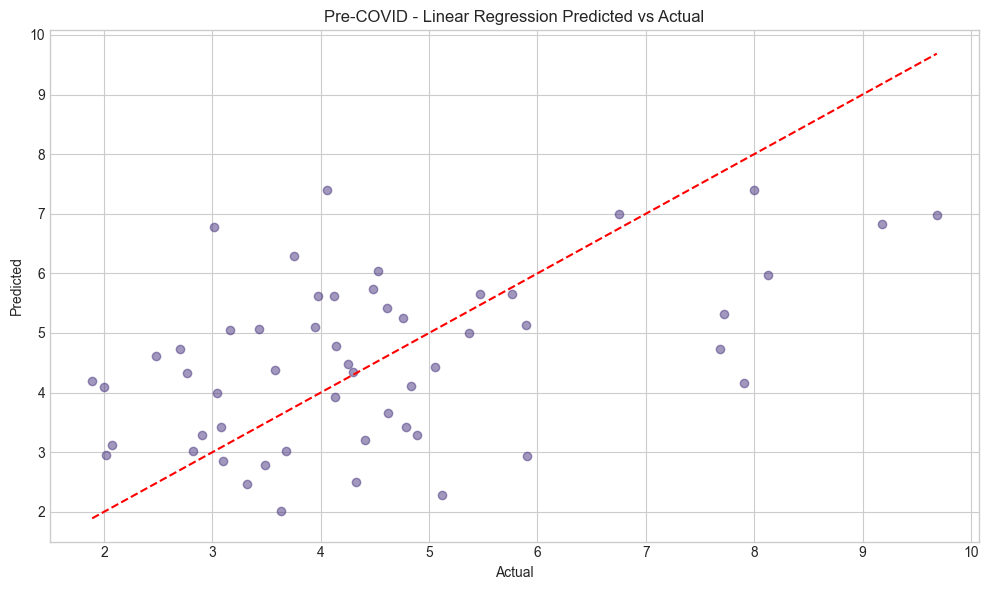


--- Pre-COVID Elastic Net ---

Pre-COVID - Elastic Net Model Evaluation Results:
MSE: 2.4208
RMSE: 1.5559
MAE: 1.2630
R²: 0.2667
Cross-validated R²: 0.2022


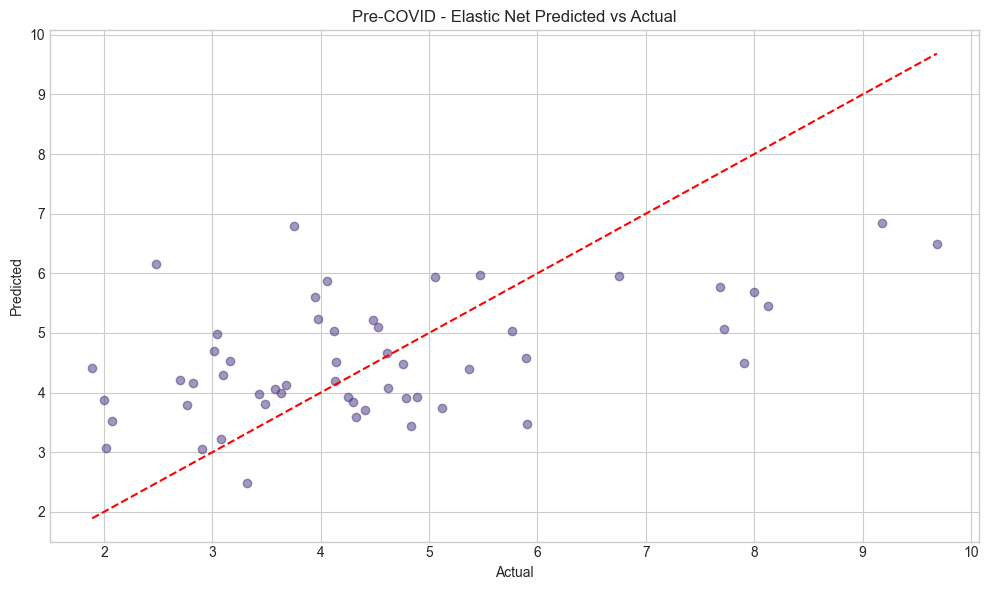


--- Pre-COVID Random Forest ---

Pre-COVID - Random Forest Model Evaluation Results:
MSE: 2.5436
RMSE: 1.5949
MAE: 1.2448
R²: 0.2295
Cross-validated R²: 0.2158


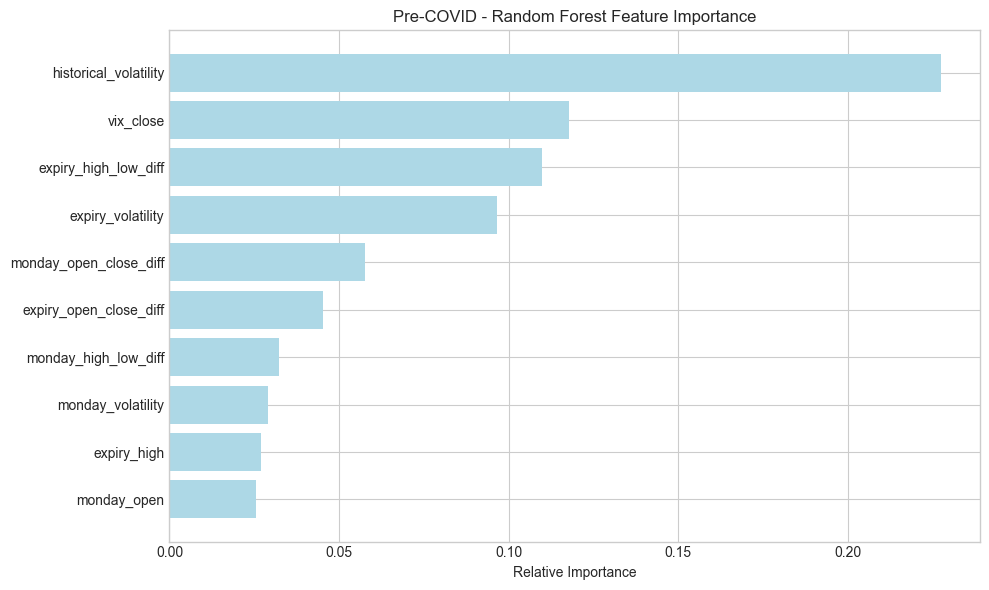

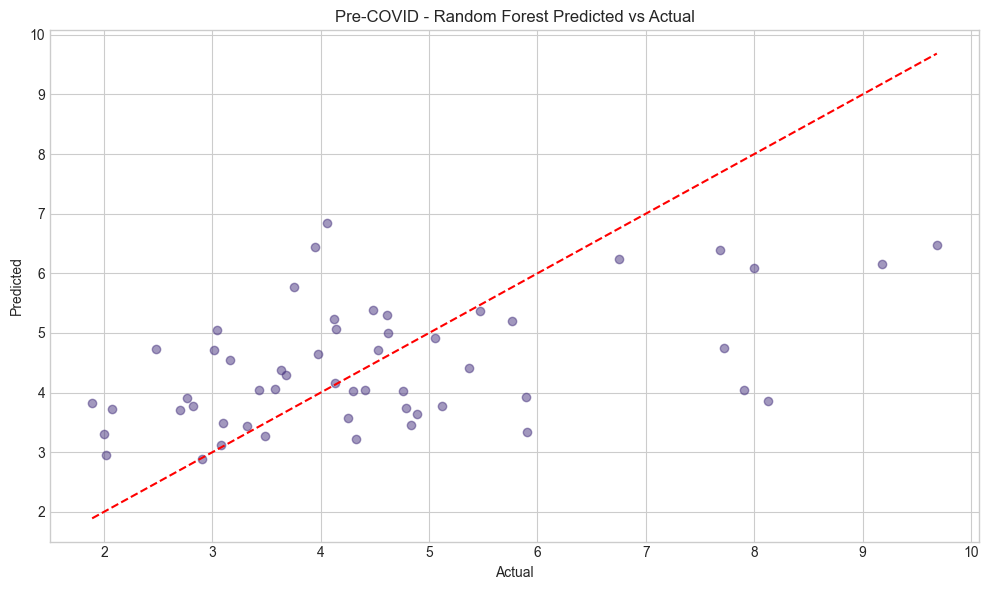


--- Pre-COVID XGBoost ---

Pre-COVID - XGBoost Model Evaluation Results:
MSE: 2.9339
RMSE: 1.7129
MAE: 1.3411
R²: 0.1113
Cross-validated R²: 0.1666


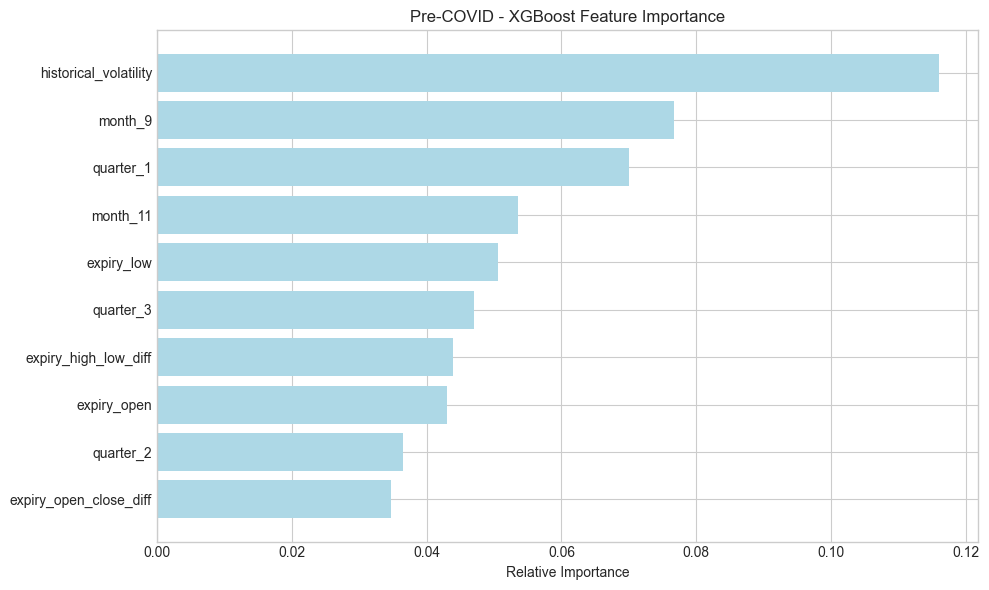

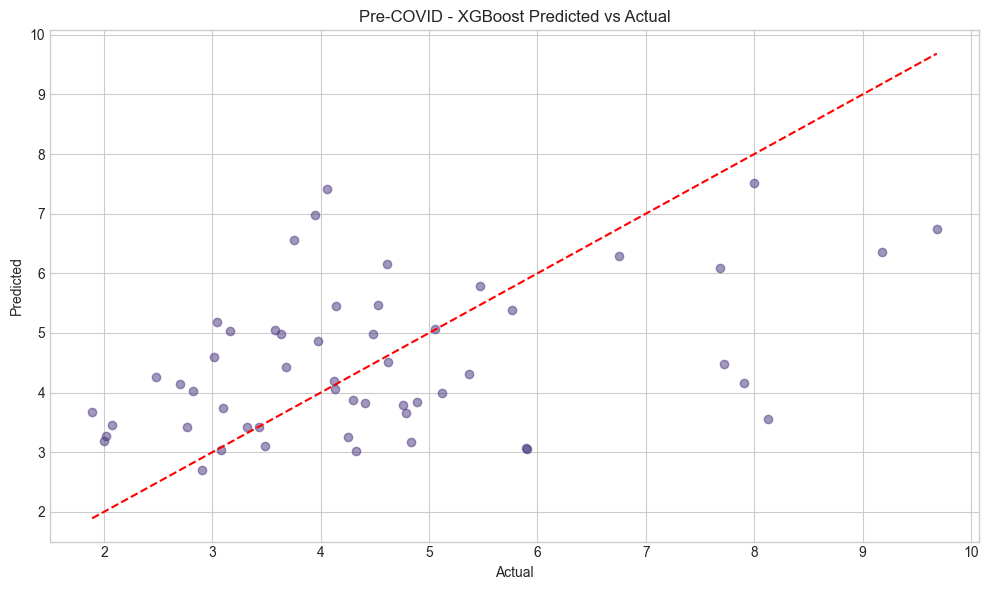


Pre-COVID Regression Models Comparison:


,Model,RMSE,MAE,R2,CV_R2
0,Linear Regression,1.686787,1.373873,0.138126,-0.095467
1,Elastic Net,1.555880,1.262961,0.266711,0.202245
2,Random Forest,1.594855,1.244815,0.229512,0.215814
3,XGBoost,1.712862,1.341097,0.111274,0.166648


In [15]:
## Cell 14: Train and Evaluate Pre-COVID Regression Models
# Initialize results storage
pre_covid_reg_results = []

# Linear Regression
print("\n--- Pre-COVID Linear Regression ---")
lr_model_pre = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_metrics_pre = evaluate_regression_model(lr_model_pre, X_pre_train, y_pre_reg_train, 
                                          X_pre_test, y_pre_reg_test, 
                                          "Pre-COVID", "Linear Regression")
pre_covid_reg_results.append(lr_metrics_pre)

# Elastic Net
print("\n--- Pre-COVID Elastic Net ---")
en_model_pre = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42))
])
en_metrics_pre = evaluate_regression_model(en_model_pre, X_pre_train, y_pre_reg_train, 
                                          X_pre_test, y_pre_reg_test, 
                                          "Pre-COVID", "Elastic Net")
pre_covid_reg_results.append(en_metrics_pre)

# Random Forest
print("\n--- Pre-COVID Random Forest ---")
rf_model_pre = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_metrics_pre = evaluate_regression_model(rf_model_pre, X_pre_train, y_pre_reg_train, 
                                          X_pre_test, y_pre_reg_test, 
                                          "Pre-COVID", "Random Forest")
pre_covid_reg_results.append(rf_metrics_pre)

# XGBoost
print("\n--- Pre-COVID XGBoost ---")
xgb_model_pre = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])
xgb_metrics_pre = evaluate_regression_model(xgb_model_pre, X_pre_train, y_pre_reg_train, 
                                           X_pre_test, y_pre_reg_test, 
                                           "Pre-COVID", "XGBoost")
pre_covid_reg_results.append(xgb_metrics_pre)

# Create a DataFrame with results
pre_covid_reg_results_df = pd.DataFrame(pre_covid_reg_results)
print("\nPre-COVID Regression Models Comparison:")
display(pre_covid_reg_results_df)


--- Post-COVID Linear Regression ---

Post-COVID - Linear Regression Model Evaluation Results:
MSE: 2.8110
RMSE: 1.6766
MAE: 1.3485
R²: 0.1666
Cross-validated R²: -0.4379


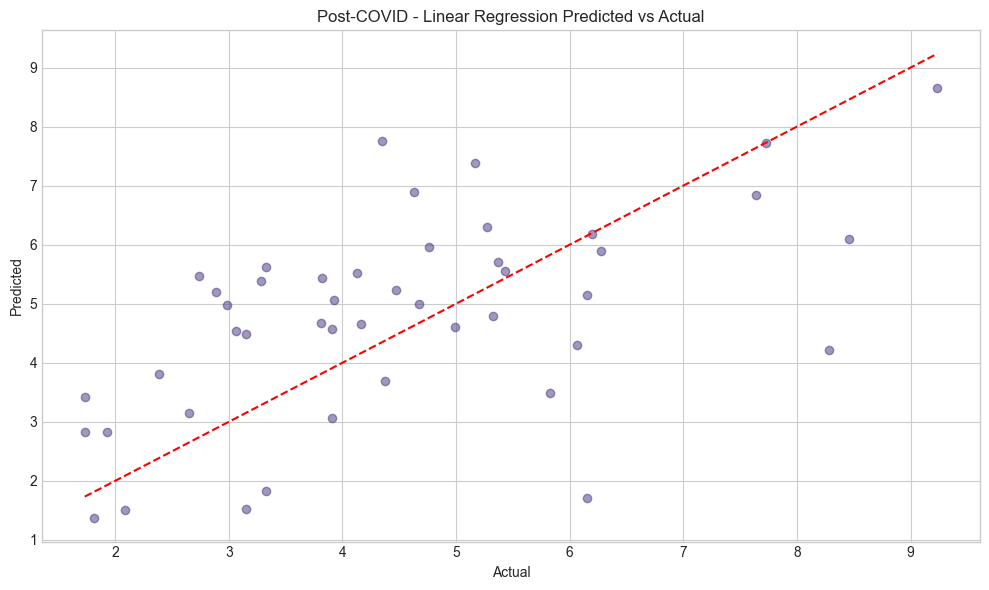


--- Post-COVID Elastic Net ---

Post-COVID - Elastic Net Model Evaluation Results:
MSE: 1.9495
RMSE: 1.3963
MAE: 1.1759
R²: 0.4220
Cross-validated R²: 0.3257


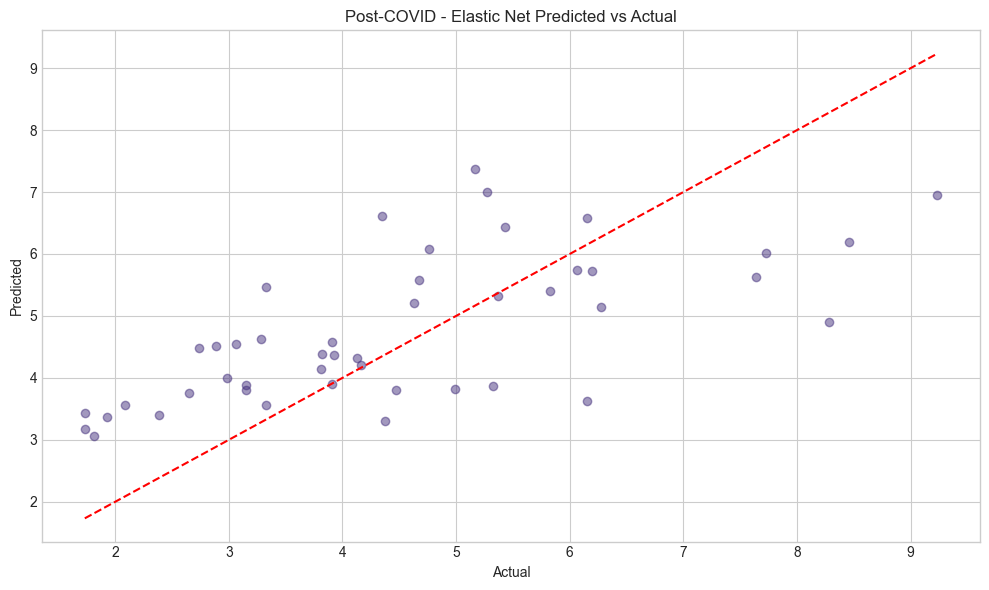


--- Post-COVID Random Forest ---

Post-COVID - Random Forest Model Evaluation Results:
MSE: 1.8459
RMSE: 1.3586
MAE: 1.1006
R²: 0.4527
Cross-validated R²: 0.2035


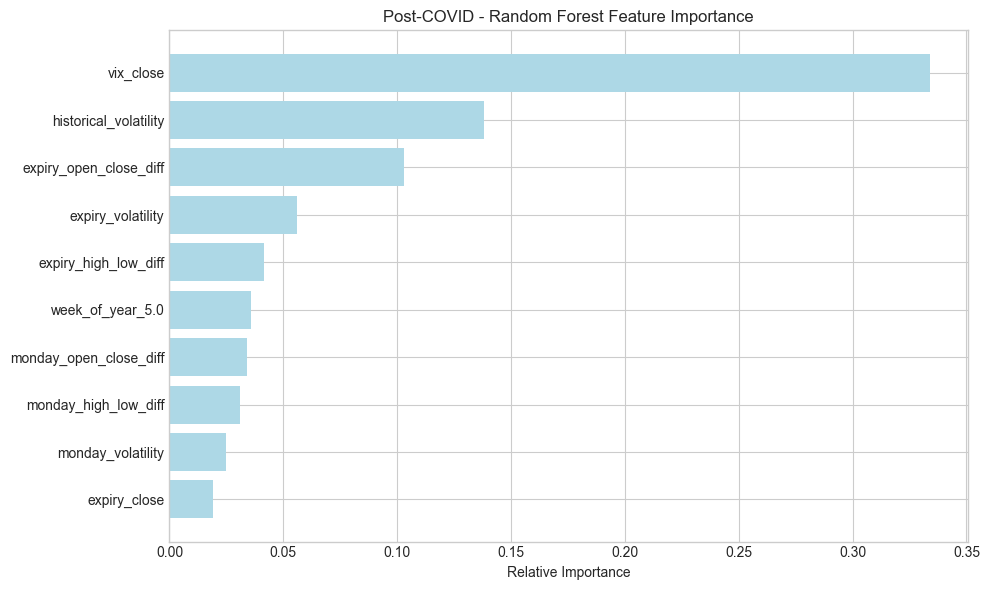

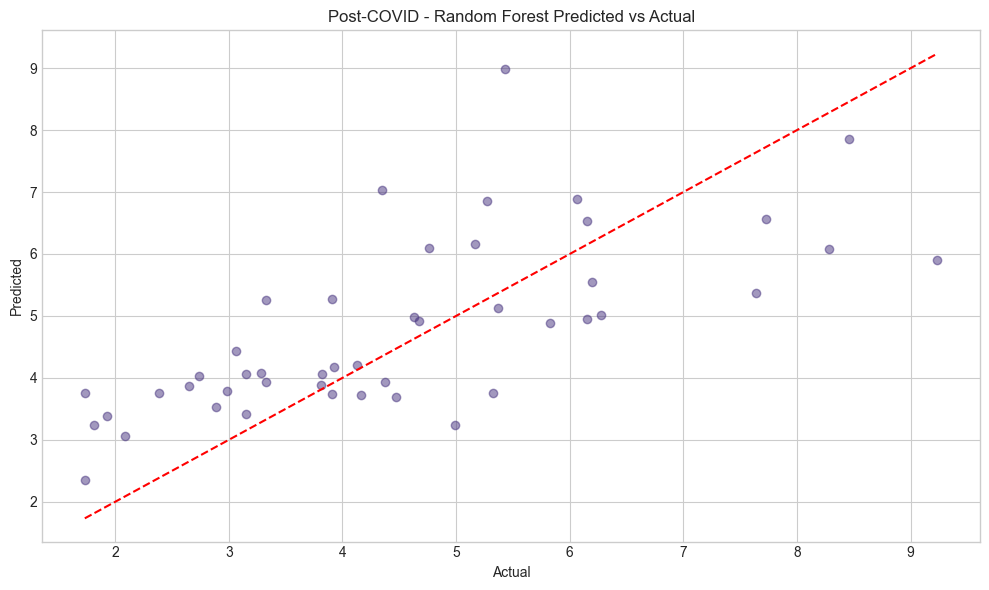


--- Post-COVID XGBoost ---

Post-COVID - XGBoost Model Evaluation Results:
MSE: 1.4428
RMSE: 1.2012
MAE: 0.9830
R²: 0.5722
Cross-validated R²: 0.0860


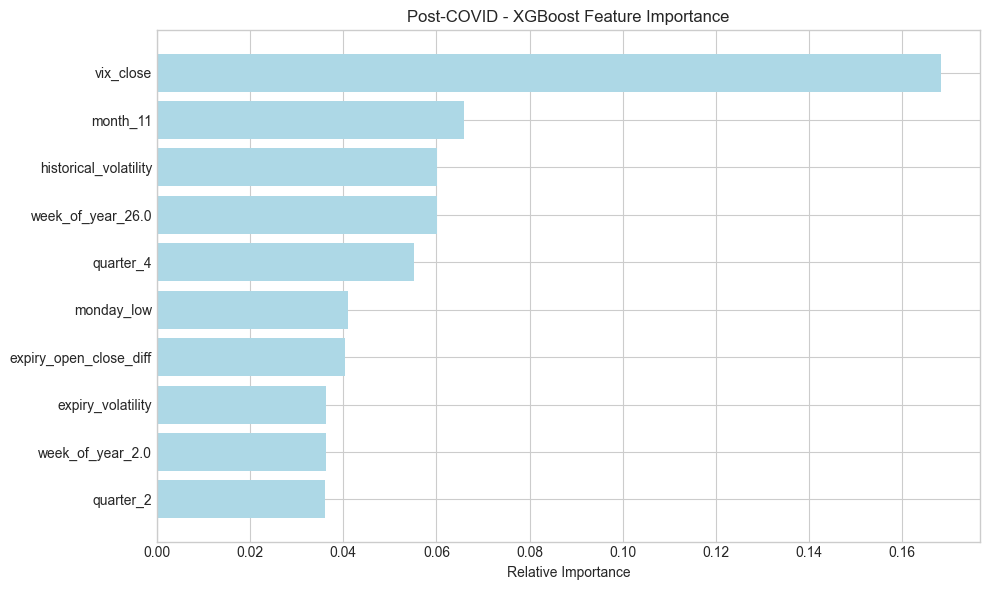

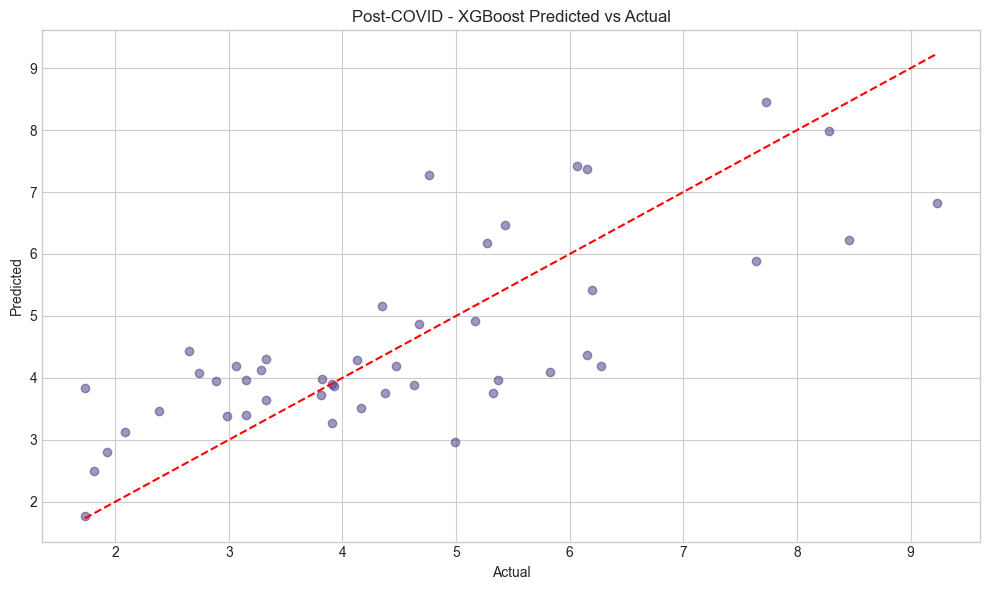


Post-COVID Regression Models Comparison:


,Model,RMSE,MAE,R2,CV_R2
0,Linear Regression,1.676596,1.348460,0.166603,-0.437923
1,Elastic Net,1.396254,1.175899,0.422005,0.325679
2,Random Forest,1.358643,1.100638,0.452724,0.203541
3,XGBoost,1.201166,0.983033,0.572239,0.086002


In [16]:
## Cell 15: Train and Evaluate Post-COVID Regression Models
# Initialize results storage
post_covid_reg_results = []

# Linear Regression
print("\n--- Post-COVID Linear Regression ---")
lr_model_post = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_metrics_post = evaluate_regression_model(lr_model_post, X_post_train, y_post_reg_train, 
                                           X_post_test, y_post_reg_test, 
                                           "Post-COVID", "Linear Regression")
post_covid_reg_results.append(lr_metrics_post)

# Elastic Net
print("\n--- Post-COVID Elastic Net ---")
en_model_post = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42))
])
en_metrics_post = evaluate_regression_model(en_model_post, X_post_train, y_post_reg_train, 
                                           X_post_test, y_post_reg_test, 
                                           "Post-COVID", "Elastic Net")
post_covid_reg_results.append(en_metrics_post)

# Random Forest
print("\n--- Post-COVID Random Forest ---")
rf_model_post = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_metrics_post = evaluate_regression_model(rf_model_post, X_post_train, y_post_reg_train, 
                                           X_post_test, y_post_reg_test, 
                                           "Post-COVID", "Random Forest")
post_covid_reg_results.append(rf_metrics_post)

# XGBoost
print("\n--- Post-COVID XGBoost ---")
xgb_model_post = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])
xgb_metrics_post = evaluate_regression_model(xgb_model_post, X_post_train, y_post_reg_train, 
                                            X_post_test, y_post_reg_test, 
                                            "Post-COVID", "XGBoost")
post_covid_reg_results.append(xgb_metrics_post)

# Create a DataFrame with results
post_covid_reg_results_df = pd.DataFrame(post_covid_reg_results)
print("\nPost-COVID Regression Models Comparison:")
display(post_covid_reg_results_df)

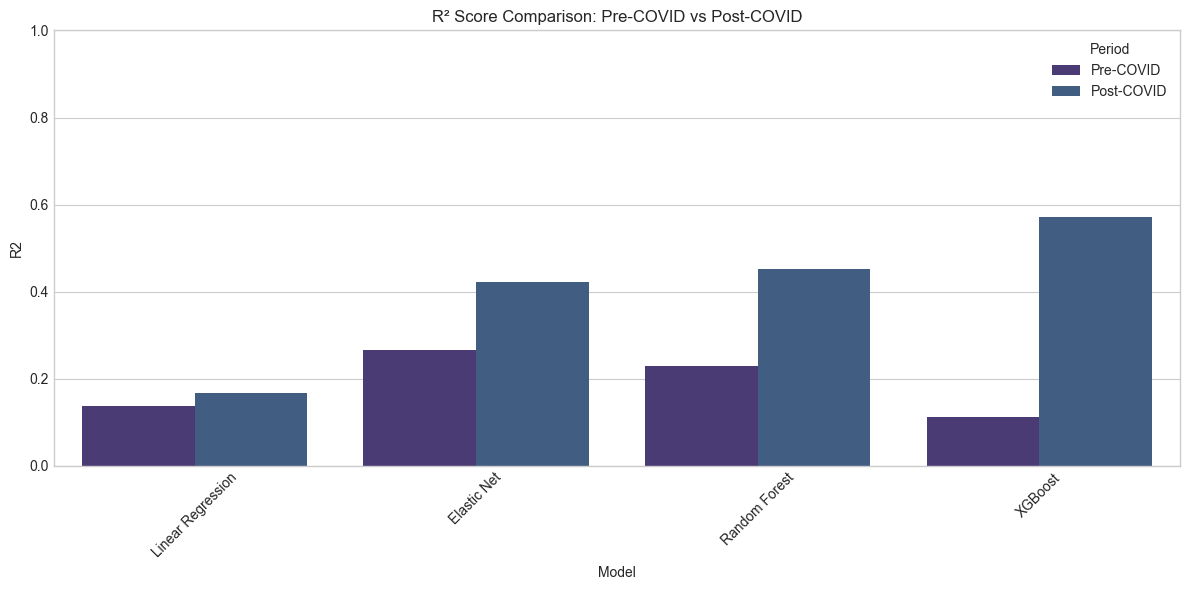

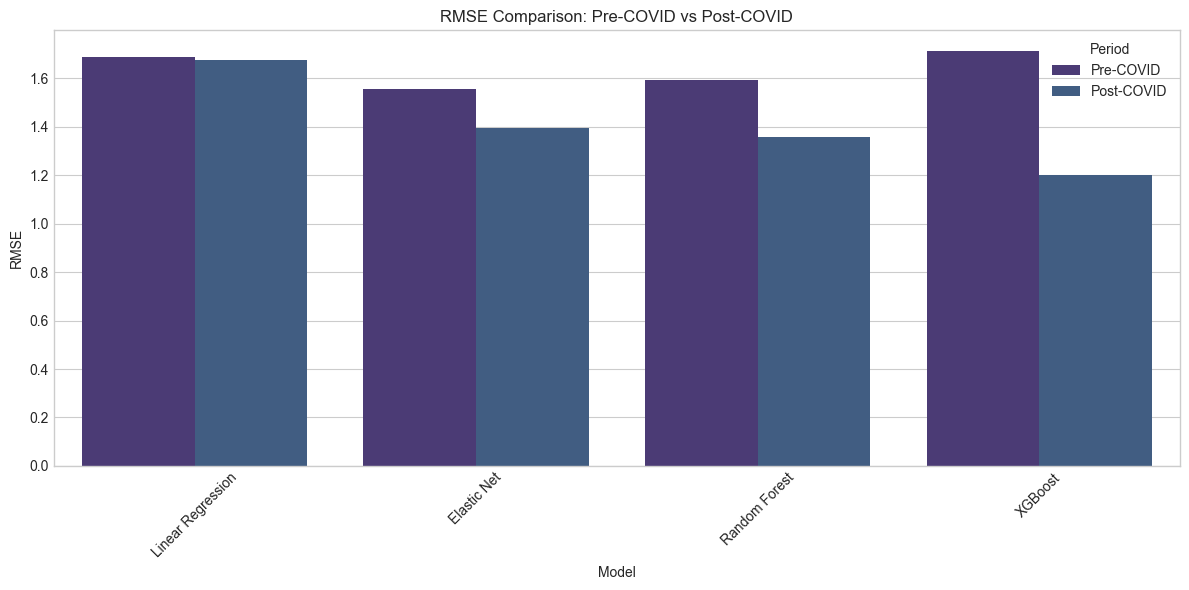

In [17]:
## Cell 16: Compare Pre-COVID and Post-COVID Regression Models
# Combine results
pre_covid_reg_results_df['Period'] = 'Pre-COVID'
post_covid_reg_results_df['Period'] = 'Post-COVID'
combined_reg_results = pd.concat([pre_covid_reg_results_df, post_covid_reg_results_df])

# Visualize comparison of R2 scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R2', hue='Period', data=combined_reg_results)
plt.title('R² Score Comparison: Pre-COVID vs Post-COVID')
plt.ylim(0, 1)  # Set y-axis limit for better visualization
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize comparison of RMSE
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='RMSE', hue='Period', data=combined_reg_results)
plt.title('RMSE Comparison: Pre-COVID vs Post-COVID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


--- Pre-COVID Logistic Regression ---

Pre-COVID - Logistic Regression Classification Model Evaluation:
Accuracy: 0.6852
Cross-validated Accuracy: 0.6184

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72        31
           1       0.62      0.65      0.64        23

    accuracy                           0.69        54
   macro avg       0.68      0.68      0.68        54
weighted avg       0.69      0.69      0.69        54


--- Pre-COVID Random Forest Classifier ---

Pre-COVID - Random Forest Classification Model Evaluation:
Accuracy: 0.6667
Cross-validated Accuracy: 0.6794

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.74      0.72        31
           1       0.62      0.57      0.59        23

    accuracy                           0.67        54
   macro avg       0.66      0.65      0.65        54
weighted avg       0.66      0.67      0.66 

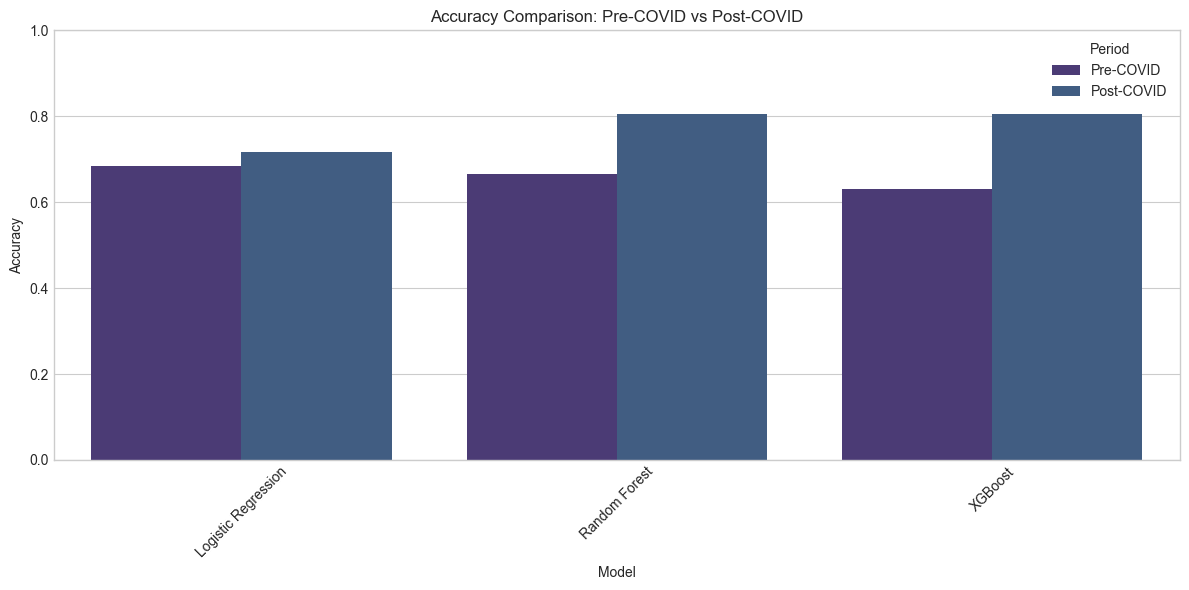

In [18]:
## Cell 17: Train and Evaluate Classification Models for Both Periods
# Pre-COVID Classification Models
pre_covid_class_results = []

# 1. Split data BEFORE applying preprocessor and other operations
X_pre = pre_covid_df[feature_columns]
y_pre_class = pre_covid_df['above_avg_range'] #Using original target

X_pre_train, X_pre_test, y_pre_class_train, y_pre_class_test = train_test_split(X_pre, y_pre_class, test_size=0.2, random_state=42)

# 2. Apply preprocessor AFTER splitting
X_pre_train = preprocessor.fit_transform(X_pre_train)
X_pre_test = preprocessor.transform(X_pre_test)

# Logistic Regression for Pre-COVID
print("\n--- Pre-COVID Logistic Regression ---")
lr_class_model_pre = Pipeline([
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
lr_class_metrics_pre = evaluate_classification_model(lr_class_model_pre, X_pre_train, y_pre_class_train,
                                                    X_pre_test, y_pre_class_test,
                                                    "Pre-COVID", "Logistic Regression")
pre_covid_class_results.append(lr_class_metrics_pre)

# Random Forest Classifier for Pre-COVID
print("\n--- Pre-COVID Random Forest Classifier ---")
rf_class_model_pre = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_class_metrics_pre = evaluate_classification_model(rf_class_model_pre, X_pre_train, y_pre_class_train,
                                                    X_pre_test, y_pre_class_test,
                                                    "Pre-COVID", "Random Forest")
pre_covid_class_results.append(rf_class_metrics_pre)

# XGBoost Classifier for Pre-COVID
print("\n--- Pre-COVID XGBoost Classifier ---")
xgb_class_model_pre = Pipeline([
    ('classifier', XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
])
xgb_class_metrics_pre = evaluate_classification_model(xgb_class_model_pre, X_pre_train, y_pre_class_train,
                                                     X_pre_test, y_pre_class_test,
                                                     "Pre-COVID", "XGBoost")
pre_covid_class_results.append(xgb_class_metrics_pre)

# Post-COVID Classification Models
post_covid_class_results = []

# Repeat previous changes
# 1. Split data BEFORE applying preprocessor and other operations
X_post = post_covid_df[feature_columns]
y_post_class = post_covid_df['above_avg_range'] #Using original target

X_post_train, X_post_test, y_post_class_train, y_post_class_test = train_test_split(X_post, y_post_class, test_size=0.2, random_state=42)

# 2. Apply preprocessor AFTER splitting
X_post_train = preprocessor.transform(X_post_train)
X_post_test = preprocessor.transform(X_post_test)

# Logistic Regression for Post-COVID
print("\n--- Post-COVID Logistic Regression ---")
lr_class_model_post = Pipeline([
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
lr_class_metrics_post = evaluate_classification_model(lr_class_model_post, X_post_train, y_post_class_train,
                                                     X_post_test, y_post_class_test,
                                                     "Post-COVID", "Logistic Regression")
post_covid_class_results.append(lr_class_metrics_post)

# Random Forest Classifier for Post-COVID
print("\n--- Post-COVID Random Forest Classifier ---")
rf_class_model_post = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_class_metrics_post = evaluate_classification_model(rf_class_model_post, X_post_train, y_post_class_train,
                                                     X_post_test, y_post_class_test,
                                                     "Post-COVID", "Random Forest")
post_covid_class_results.append(rf_class_metrics_post)

# XGBoost Classifier for Post-COVID
print("\n--- Post-COVID XGBoost Classifier ---")
xgb_class_model_post = Pipeline([
    ('classifier', XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
])
xgb_class_metrics_post = evaluate_classification_model(xgb_class_model_post, X_post_train, y_post_class_train,
                                                      X_post_test, y_post_class_test,
                                                      "Post-COVID", "XGBoost")
post_covid_class_results.append(xgb_class_metrics_post)

# Create DataFrames with results
pre_covid_class_results_df = pd.DataFrame(pre_covid_class_results)
post_covid_class_results_df = pd.DataFrame(post_covid_class_results)

pre_covid_class_results_df['Period'] = 'Pre-COVID'
post_covid_class_results_df['Period'] = 'Post-COVID'
combined_class_results = pd.concat([pre_covid_class_results_df, post_covid_class_results_df])

# Visualize comparison of Accuracy
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', hue='Period', data=combined_class_results)
plt.title('Accuracy Comparison: Pre-COVID vs Post-COVID')
plt.ylim(0, 1)  # Set y-axis limit for better visualization
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


--- Pre-COVID Direction Logistic Regression ---
X_train shape: (212, 85)
X_test shape: (54, 85)
y_train shape: (212,)
y_test shape: (54,)
y_train unique values: [0 1]
y_test unique values: [0 1]
Are X_train, y_train same length: True
Are X_test, y_test same length: True
Are X_train, X_test same data type: True
Pre-COVID Direction - Logistic Regression Classification Results:
Accuracy: 0.6852
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.71      0.72        31
           1       0.62      0.65      0.64        23

    accuracy                           0.69        54
   macro avg       0.68      0.68      0.68        54
weighted avg       0.69      0.69      0.69        54

Cross-Validation Accuracy Scores: [0.58139535 0.55813953 0.66666667 0.57142857 0.71428571]
Mean CV Accuracy Score: 0.6184

--- Pre-COVID Direction Random Forest Classifier ---
X_train shape: (212, 85)
X_test shape: (54, 85)
y_train shape: (212,)
y_test 

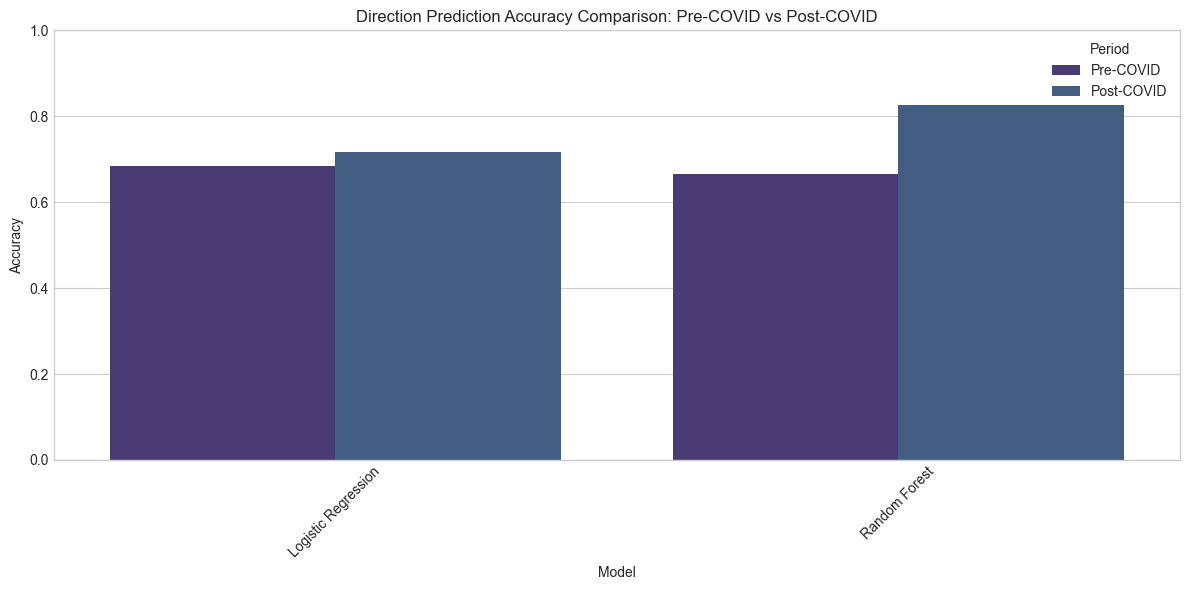

In [19]:
## Cell 18: Direction Classification Models
# Pre-COVID Direction Classification Models
pre_covid_dir_results = []

# Function to convert to rows rather than length
def safe_len(X):
  if hasattr(X, 'shape'):
    return X.shape[0]
  return len(X)

# Modify evaluate class model. 
def evaluate_classification_model(model, X_train, y_train, X_test, y_test, period, model_name):
    """
    Evaluates classification models and returns metrics
    """
    # Sanity Checks
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"y_train unique values: {np.unique(y_train)}")
    print(f"y_test unique values: {np.unique(y_test)}")
    print(f"Are X_train, y_train same length: {safe_len(X_train) == len(y_train)}") #changed to rows
    print(f"Are X_test, y_test same length: {safe_len(X_test) == len(y_test)}")#changed to rows
    print(f"Are X_train, X_test same data type: {type(X_train) == type(X_test)}")

    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Print results
    print(f"{period} - {model_name} Classification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-Validation Accuracy Scores: {cv_scores}")
    print(f"Mean CV Accuracy Score: {cv_scores.mean():.4f}")
    
    
    return {
        'Model': model_name, # Added Model field for later comparison
        'Accuracy': accuracy,
        'Cross Validation': cv_scores.mean()
    }

# Modify evaluate class model. 
# 1. Split data BEFORE applying preprocessor and other operations
X_pre = pre_covid_df[feature_columns]
y_pre_class = pre_covid_df['above_avg_range'] #Using original target

# Check number of values are at least 2
if y_pre_class.nunique() > 1:

    X_pre_train, X_pre_test, y_pre_class_train, y_pre_class_test = train_test_split(X_pre, y_pre_class, test_size=0.2, random_state=42)

    # 2. Apply preprocessor AFTER splitting
    X_pre_train = preprocessor.fit_transform(X_pre_train)
    X_pre_test = preprocessor.transform(X_pre_test)
else:
    print("The number of unique categories for pre_covid classification is less than 2.")
    #continue;
## Since the model won't be trained or evaluated, set dummy metrics
    pre_covid_results = {'Model': "Logistic Regression", "Accuracy":"No data", "Cross Validation":"No Data"}

# Logistic Regression for Pre-COVID Direction
print("\n--- Pre-COVID Direction Logistic Regression ---")
lr_dir_model_pre = Pipeline([
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
if 'X_pre_train' in locals():
    lr_dir_metrics_pre = evaluate_classification_model(lr_dir_model_pre, X_pre_train, y_pre_class_train, 
                                                  X_pre_test, y_pre_class_test, 
                                                  "Pre-COVID Direction", "Logistic Regression")
else:
    lr_dir_metrics_pre = {'Model': "Logistic Regression", "Accuracy":"No data", "Cross Validation":"No Data"}

pre_covid_dir_results.append(lr_dir_metrics_pre)

# Random Forest Classifier for Pre-COVID Direction
print("\n--- Pre-COVID Direction Random Forest Classifier ---")
rf_dir_model_pre = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
if 'X_pre_train' in locals():
    rf_dir_metrics_pre = evaluate_classification_model(rf_dir_model_pre, X_pre_train, y_pre_class_train, 
                                                  X_pre_test, y_pre_class_test, 
                                                  "Pre-COVID Direction", "Random Forest")
else:
    rf_dir_metrics_pre = {'Model': "Logistic Regression", "Accuracy":"No data", "Cross Validation":"No Data"}
pre_covid_dir_results.append(rf_dir_metrics_pre)

# Post-COVID Direction Classification Models
post_covid_dir_results = []

# 1. Split data BEFORE applying preprocessor and other operations
X_post = post_covid_df[feature_columns]
y_post_class = post_covid_df['above_avg_range'] #Using original target

# Check number of values are at least 2
if y_post_class.nunique() > 1:

    X_post_train, X_post_test, y_post_class_train, y_post_class_test = train_test_split(X_post, y_post_class, test_size=0.2, random_state=42)

    # 2. Apply preprocessor AFTER splitting
    X_post_train = preprocessor.fit_transform(X_post_train)
    X_post_test = preprocessor.transform(X_post_test)
else:
    print("The number of unique categories for post covid classification is less than 2.")
    #continue;
    post_covid_results = {'Model': "Logistic Regression", "Accuracy":"No data", "Cross Validation":"No Data"}

# Logistic Regression for Post-COVID Direction
print("\n--- Post-COVID Direction Logistic Regression ---")
lr_dir_model_post = Pipeline([
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
if 'X_post_train' in locals():

    lr_dir_metrics_post = evaluate_classification_model(lr_dir_model_post, X_post_train, y_post_class_train, 
                                                       X_post_test, y_post_class_test, 
                                                       "Post-COVID Direction", "Logistic Regression")
else:
    lr_dir_metrics_post = {'Model': "Logistic Regression", "Accuracy":"No data", "Cross Validation":"No Data"}

post_covid_dir_results.append(lr_dir_metrics_post)

# Random Forest Classifier for Post-COVID Direction
print("\n--- Post-COVID Direction Random Forest Classifier ---")
rf_dir_model_post = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
if 'X_post_train' in locals():
    rf_dir_metrics_post = evaluate_classification_model(rf_dir_model_post, X_post_train, y_post_class_train, 
                                                       X_post_test, y_post_class_test, 
                                                       "Post-COVID Direction", "Random Forest")
else:
        rf_dir_metrics_post = {'Model': "Logistic Regression", "Accuracy":"No data", "Cross Validation":"No Data"}
post_covid_dir_results.append(rf_dir_metrics_post)

# Create DataFrames with results
pre_covid_dir_results_df = pd.DataFrame(pre_covid_dir_results)
post_covid_dir_results_df = pd.DataFrame(post_covid_dir_results)

pre_covid_dir_results_df['Period'] = 'Pre-COVID'
post_covid_dir_results_df['Period'] = 'Post-COVID'
combined_dir_results = pd.concat([pre_covid_dir_results_df, post_covid_dir_results_df])

# Visualize comparison of Direction Accuracy
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', hue='Period', data=combined_dir_results)
plt.title('Direction Prediction Accuracy Comparison: Pre-COVID vs Post-COVID')
plt.ylim(0, 1)  # Set y-axis limit for better visualization
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


--- Pre-COVID High Range XGBoost ---
X_train data type is  <class 'pandas.core.frame.DataFrame'>
y_train data type is  <class 'pandas.core.series.Series'>
X_test data type is  <class 'pandas.core.frame.DataFrame'>
y_test data type is  <class 'pandas.core.series.Series'>
X_train shape is  (212, 84)
y_train shape is  (212,)
X_test shape is  (54, 84)
y_test shape is  (54,)
Same number of rows in the train : True
Same number of rows in the train : True
Pre-COVID High Range - XGBoost Regression Results:
Mean Squared Error: 1.0991
Root Mean Squared Error: 1.0484
Mean Absolute Error: 0.7878
R² Score: 0.4543
Cross-Validation R2 Scores: [0.35753232 0.31303704 0.38149071 0.01454903 0.18766519]
Mean CV R2 Score: 0.2509


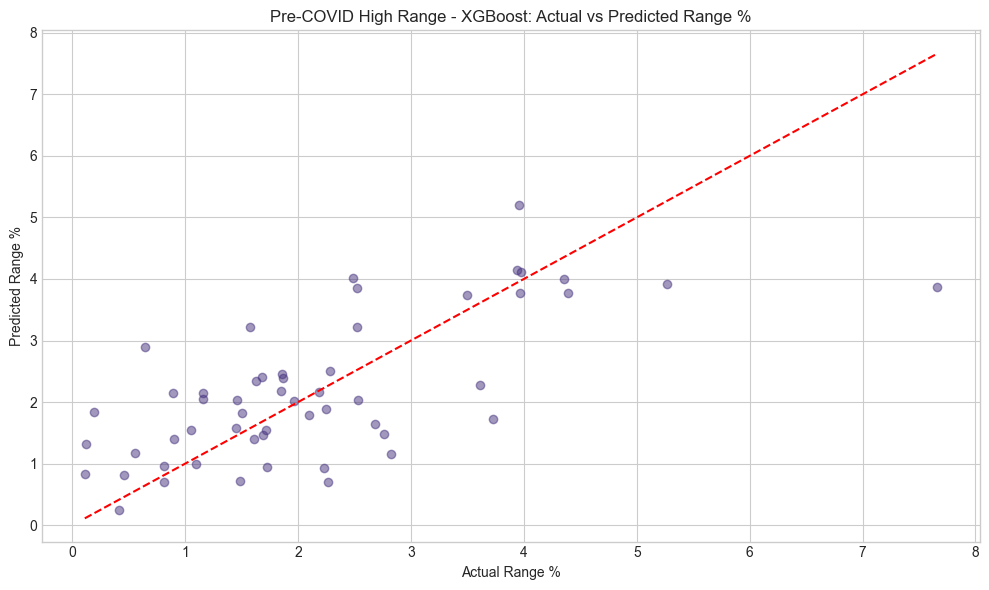


--- Pre-COVID Low Range XGBoost ---
X_train data type is  <class 'pandas.core.frame.DataFrame'>
y_train data type is  <class 'pandas.core.series.Series'>
X_test data type is  <class 'pandas.core.frame.DataFrame'>
y_test data type is  <class 'pandas.core.series.Series'>
X_train shape is  (212, 84)
y_train shape is  (212,)
X_test shape is  (54, 84)
y_test shape is  (54,)
Same number of rows in the train : True
Same number of rows in the train : True
Pre-COVID Low Range - XGBoost Regression Results:
Mean Squared Error: 2.0193
Root Mean Squared Error: 1.4210
Mean Absolute Error: 1.1072
R² Score: 0.4864
Cross-Validation R2 Scores: [-0.10364608  0.30409311  0.08357481  0.12777033  0.35532975]
Mean CV R2 Score: 0.1534


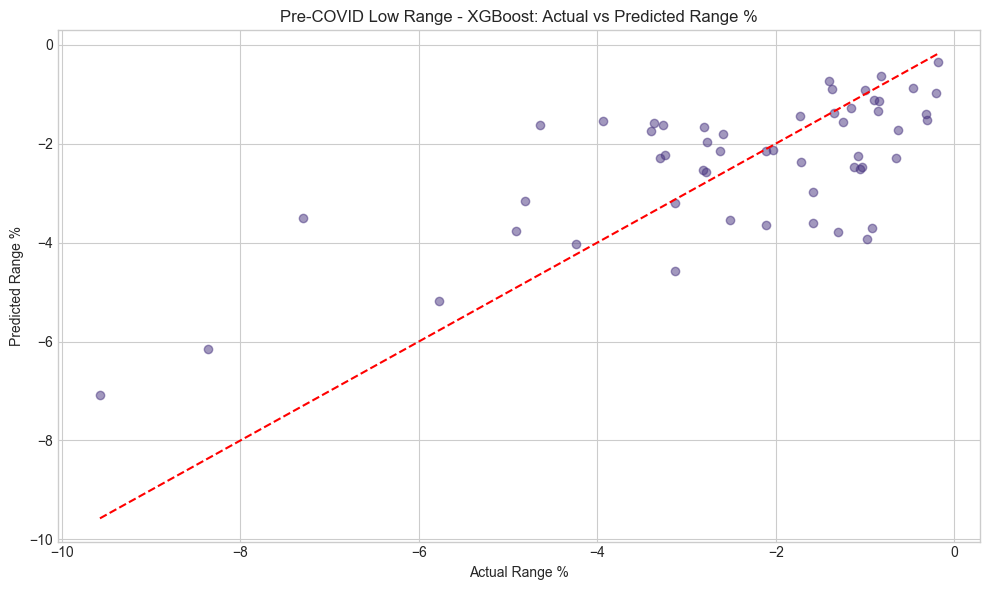


--- Post-COVID High Range XGBoost ---
X_train data type is  <class 'pandas.core.frame.DataFrame'>
y_train data type is  <class 'pandas.core.series.Series'>
X_test data type is  <class 'pandas.core.frame.DataFrame'>
y_test data type is  <class 'pandas.core.series.Series'>
X_train shape is  (181, 84)
y_train shape is  (181,)
X_test shape is  (46, 84)
y_test shape is  (46,)
Same number of rows in the train : True
Same number of rows in the train : True
Post-COVID High Range - XGBoost Regression Results:
Mean Squared Error: 3.1651
Root Mean Squared Error: 1.7791
Mean Absolute Error: 1.2957
R² Score: 0.0614
Cross-Validation R2 Scores: [0.11219459 0.36868758 0.25816005 0.1533782  0.37002864]
Mean CV R2 Score: 0.2525


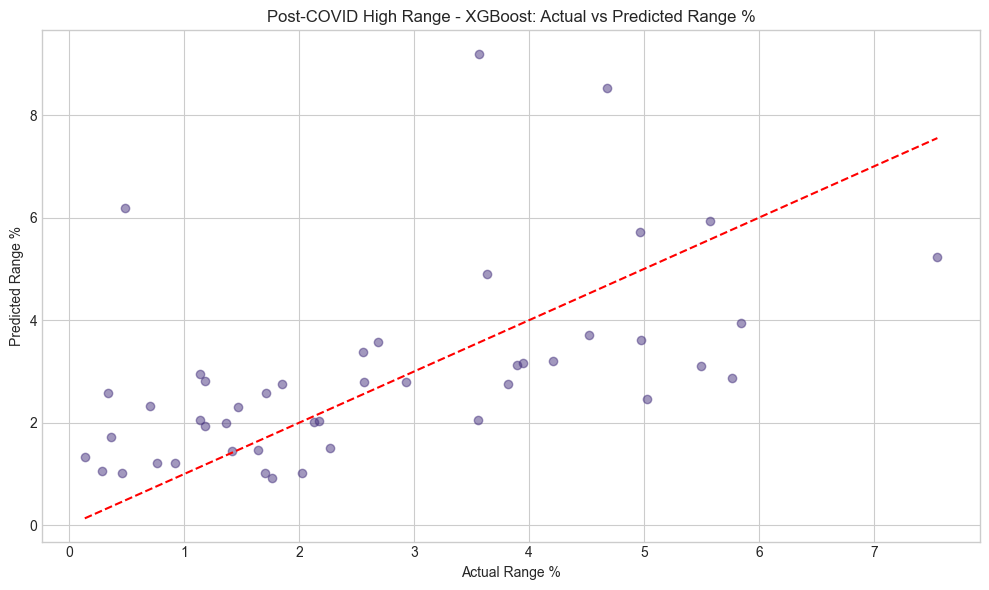


--- Post-COVID Low Range XGBoost ---
X_train data type is  <class 'pandas.core.frame.DataFrame'>
y_train data type is  <class 'pandas.core.series.Series'>
X_test data type is  <class 'pandas.core.frame.DataFrame'>
y_test data type is  <class 'pandas.core.series.Series'>
X_train shape is  (181, 84)
y_train shape is  (181,)
X_test shape is  (46, 84)
y_test shape is  (46,)
Same number of rows in the train : True
Same number of rows in the train : True
Post-COVID Low Range - XGBoost Regression Results:
Mean Squared Error: 3.4184
Root Mean Squared Error: 1.8489
Mean Absolute Error: 1.4078
R² Score: 0.0593
Cross-Validation R2 Scores: [-0.00742081  0.05655535  0.36657571  0.16431737 -0.08210224]
Mean CV R2 Score: 0.0996


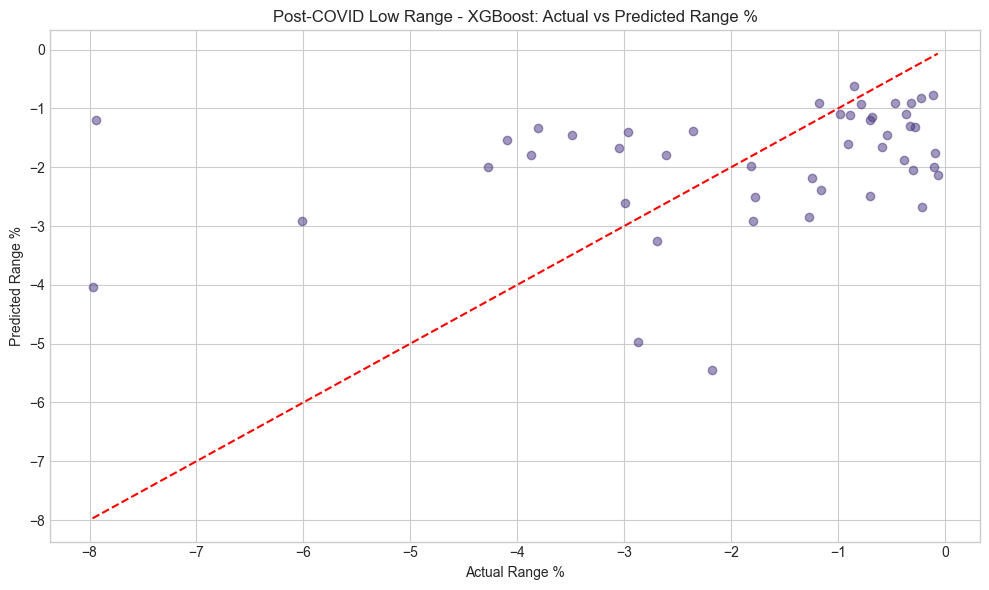

In [20]:
## Cell 19: High and Low Range Models
# Pre-COVID High Range Model

# Function to convert csr_matrix to DataFrame
def to_dense_df(X):
  if hasattr(X, 'toarray'):
    return pd.DataFrame(X.toarray())
  return X
def safe_len(X):
  if hasattr(X, 'shape'):
    return X.shape[0]
  return len(X)

# Modify evaluate regression model to output and handle sparse matrix
def evaluate_regression_model(model, X_train, y_train, X_test, y_test, period, model_name):
    """
    Evaluates a regression model and returns metrics.

    Note: Removed feature importance section as it causes issues with sparse matrices and is nonessential.
    """

    # Sanity Checks to debug
    print(f"X_train data type is ", type(X_train))
    print(f"y_train data type is ", type(y_train))
    print(f"X_test data type is ", type(X_test))
    print(f"y_test data type is ", type(y_test))
    print(f"X_train shape is ", X_train.shape if hasattr(X_train, 'shape') else X_train.shape) #CHANGED TO shape vs len
    print(f"y_train shape is ", y_train.shape)
    print(f"X_test shape is ", X_test.shape if hasattr(X_test, 'shape') else X_test.shape)#CHANGED TO shape vs len
    print(f"y_test shape is ", y_test.shape)
    print(f"Same number of rows in the train : {safe_len(X_train) == len(y_train)}")
    print(f"Same number of rows in the train : {safe_len(X_test) == len(y_test)}")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print results
    print(f"{period} - {model_name} Regression Results:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print(f"Cross-Validation R2 Scores: {cv_scores}")
    print(f"Mean CV R2 Score: {cv_scores.mean():.4f}")

    # Plot predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Range %')
    plt.ylabel('Predicted Range %')
    plt.title(f'{period} - {model_name}: Actual vs Predicted Range %')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    return {
        'Model': model_name,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'cv_r2': cv_scores.mean(),
    }

# 1. Split data BEFORE applying preprocessor and other operations
X_pre = pre_covid_df[feature_columns]
y_pre_high = pre_covid_df['high_range_percentage']
y_pre_low = pre_covid_df['low_range_percentage']

# Check number of values are at least 2
X_pre_train, X_pre_test, y_pre_high_train, y_pre_high_test = train_test_split(X_pre,y_pre_high, test_size=0.2, random_state=42)
X_pre_train = to_dense_df(preprocessor.transform(X_pre_train)) #Added this line
X_pre_test = to_dense_df(preprocessor.transform(X_pre_test))#Added this line

# Pre-COVID High Range Model
print("\n--- Pre-COVID High Range XGBoost ---")
xgb_high_model_pre = Pipeline([
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])
xgb_high_metrics_pre = evaluate_regression_model(xgb_high_model_pre, X_pre_train, y_pre_high_train, 
                                                X_pre_test, y_pre_high_test, 
                                                "Pre-COVID High Range", "XGBoost")

# Pre-COVID Low Range Model
print("\n--- Pre-COVID Low Range XGBoost ---")
xgb_low_model_pre = Pipeline([
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])
xgb_low_metrics_pre = evaluate_regression_model(xgb_low_model_pre, X_pre_train, y_pre_low_train, 
                                               X_pre_test, y_pre_low_test, 
                                               "Pre-COVID Low Range", "XGBoost")

# Post-COVID - Run the same split

X_post = post_covid_df[feature_columns]
y_post_high = post_covid_df['high_range_percentage']
y_post_low = post_covid_df['low_range_percentage']

X_post_train, X_post_test, y_post_high_train, y_post_high_test = train_test_split(X_post,y_post_high, test_size=0.2, random_state=42)
X_post_train = to_dense_df(preprocessor.transform(X_post_train))#Added this line
X_post_test = to_dense_df(preprocessor.transform(X_post_test))#Added this line

# Post-COVID High Range Model
print("\n--- Post-COVID High Range XGBoost ---")
xgb_high_model_post = Pipeline([
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])
xgb_high_metrics_post = evaluate_regression_model(xgb_high_model_post, X_post_train, y_post_high_train, 
                                                 X_post_test, y_post_high_test, 
                                                 "Post-COVID High Range", "XGBoost")

# Post-COVID Low Range Model
print("\n--- Post-COVID Low Range XGBoost ---")
xgb_low_model_post = Pipeline([
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])
xgb_low_metrics_post = evaluate_regression_model(xgb_low_model_post, X_post_train, y_post_low_train, 
                                                X_post_test, y_post_low_test, 
                                                "Post-COVID Low Range", "XGBoost")

Print the regression features used ['monday_open', 'monday_low', 'monday_high', 'monday_close', 'expiry_open', 'expiry_low', 'expiry_high', 'expiry_close', 'vix_close', 'monday_open_close_diff', 'monday_high_low_diff', 'expiry_open_close_diff', 'expiry_high_low_diff', 'monday_volatility', 'expiry_volatility', 'historical_volatility', 'month', 'week_of_year', 'quarter']


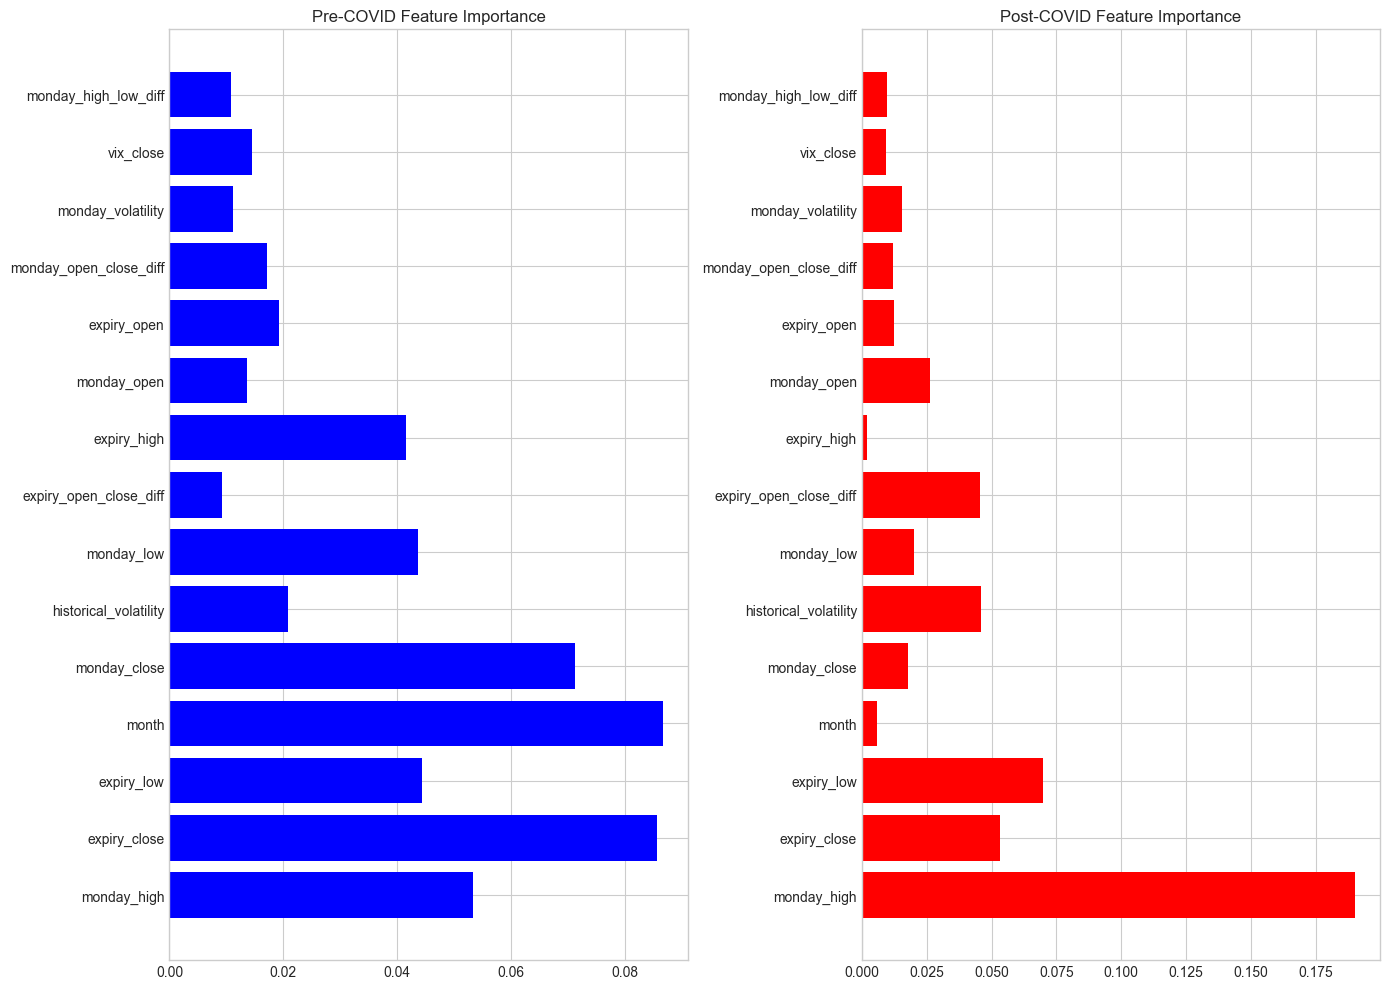


Top 15 Features by Importance:


,Feature,Pre-COVID Importance,Post-COVID Importance,Average Importance
2,monday_high,0.053360,0.190325,0.121842
7,expiry_close,0.085539,0.053170,0.069355
5,expiry_low,0.044330,0.069872,0.057101
16,month,0.086597,0.005917,0.046257
3,monday_close,0.071178,0.017853,0.044515
15,historical_volatility,0.020840,0.045777,0.033309
1,monday_low,0.043598,0.020010,0.031804
11,expiry_open_close_diff,0.009207,0.045565,0.027386
6,expiry_high,0.041459,0.001907,0.021683
0,monday_open,0.013601,0.026073,0.019837


In [21]:
## Cell 20: Advanced Analysis - Feature Importance Comparison
# Get feature importance from Random Forest models
def get_feature_importance(model):
    """Extract feature importance from a trained model"""
    if hasattr(model, 'steps'):
        if hasattr(model.steps[-1][1], 'feature_importances_'):
            return model.steps[-1][1].feature_importances_
    elif hasattr(model, 'feature_importances_'):
        return model.feature_importances_
    return None

print("Print the regression features used", feature_columns)

#For feature Importance this has to be non Sparse objects

# Extract feature names after preprocessing
preprocessor.fit(X_pre)

numerical_features_processed = []
categorical_features_processed = []
ohe = preprocessor.named_transformers_['cat']
categorical_features_processed = ohe.get_feature_names_out(categorical_features).tolist() #Fix

all_feature_names = feature_columns #list(X_pre.columns)#numerical_features + categorical_features_processed

# Get feature importances
rf_pre_importances = get_feature_importance(xgb_high_model_pre)
rf_post_importances = get_feature_importance(xgb_high_model_post)

# Compare feature importances
if rf_pre_importances is not None and rf_post_importances is not None:
    # Determine the length to use
    min_len = min(len(rf_pre_importances), len(rf_post_importances), len(all_feature_names))

    # Trim the data to the length
    feature_list_adjusted = all_feature_names[:min_len]
    rf_pre_importances_adj = rf_pre_importances[:min_len]
    rf_post_importances_adj = rf_post_importances[:min_len]

    # Create a DataFrame for comparison
    feature_importance_df = pd.DataFrame({
        'Feature': feature_list_adjusted,
        'Pre-COVID Importance': rf_pre_importances_adj,
        'Post-COVID Importance': rf_post_importances_adj
    })
    
    # Sort by average importance
    feature_importance_df['Average Importance'] = (feature_importance_df['Pre-COVID Importance'] + 
                                                  feature_importance_df['Post-COVID Importance']) / 2
    feature_importance_df = feature_importance_df.sort_values('Average Importance', ascending=False).head(15)
    
    # Plot comparison
    plt.figure(figsize=(14, 10))
    
    # Plot Pre-COVID importance
    plt.subplot(1, 2, 1)
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Pre-COVID Importance'], color='blue')
    plt.title('Pre-COVID Feature Importance')
    plt.tight_layout()
    
    # Plot Post-COVID importance
    plt.subplot(1, 2, 2)
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Post-COVID Importance'], color='red')
    plt.title('Post-COVID Feature Importance')
    plt.tight_layout()
    
    plt.show()
    
    # Display the importance values
    print("\nTop 15 Features by Importance:")
    display(feature_importance_df)

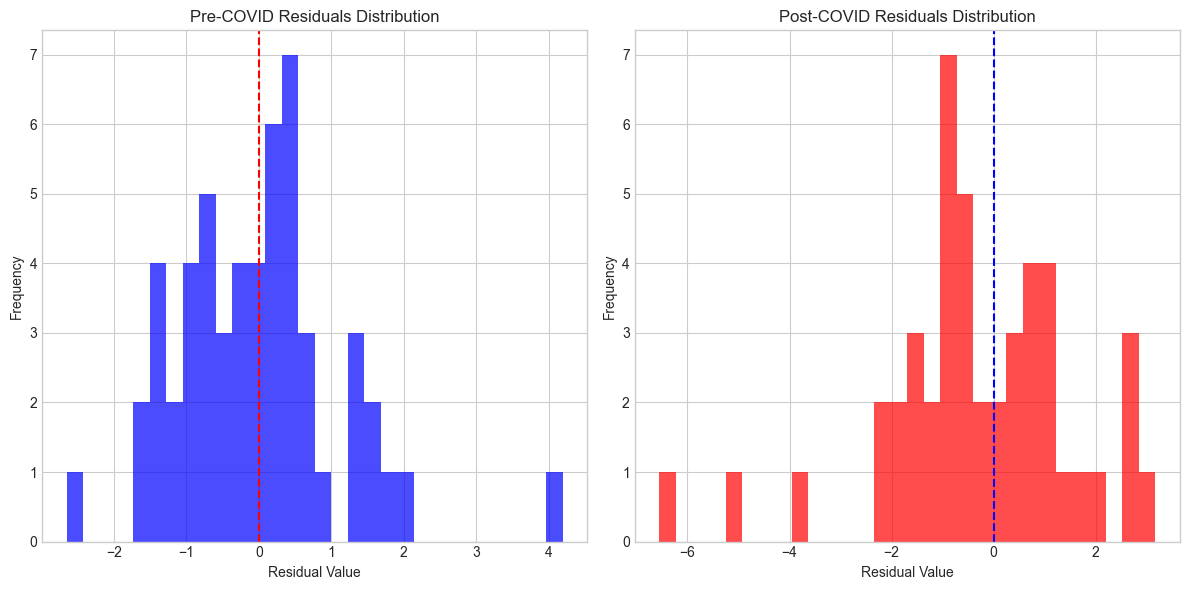


Pre-COVID Residuals - Mean: -0.0179, Std: 1.1434

Post-COVID Residuals - Mean: -0.3515, Std: 1.8912


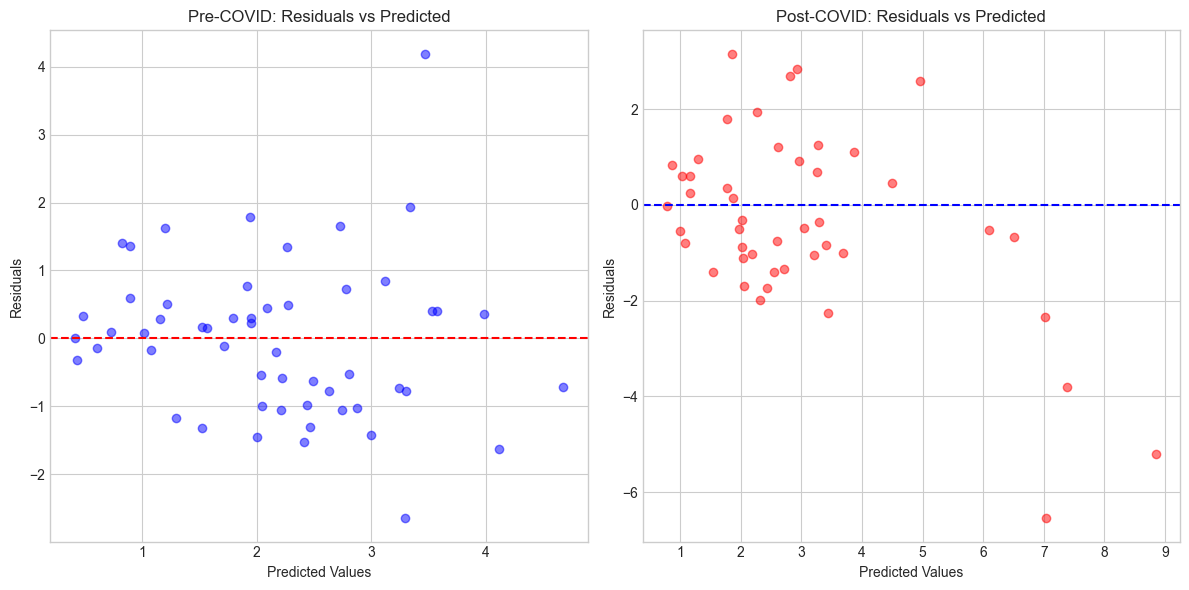

In [22]:
## Cell 21: Error Analysis - Residuals Comparison
# Calculate residuals for best models (XGBoost in this case)

# Use a new preprocessors, X_train and X_test to remove past objects
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X_pre = pre_covid_df[feature_columns]
y_pre_high = pre_covid_df['high_range_percentage']
y_pre_low = pre_covid_df['low_range_percentage']

# Check number of values are at least 2
X_pre_train, X_pre_test, y_pre_high_train, y_pre_high_test = train_test_split(X_pre,y_pre_high, test_size=0.2, random_state=42)
X_pre_train = to_dense_df(preprocessor_reg.fit_transform(X_pre_train))
X_pre_test = to_dense_df(preprocessor_reg.transform(X_pre_test))

# Train a new regression Model
xgb_model_pre = XGBRegressor()
xgb_model_pre.fit(X_pre_train, y_pre_high_train) #High vs test, but then y has same variable as train in scatter Plot

X_post = post_covid_df[feature_columns]
y_post_high = post_covid_df['high_range_percentage']
y_post_low = post_covid_df['low_range_percentage']

X_post_train, X_post_test, y_post_high_train, y_post_high_test = train_test_split(X_post,y_post_high, test_size=0.2, random_state=42)
X_post_train = to_dense_df(preprocessor_reg.fit_transform(X_post_train))
X_post_test = to_dense_df(preprocessor_reg.transform(X_post_test))

xgb_model_post = XGBRegressor()
xgb_model_post.fit(X_post_train, y_post_high_train) #High vs test, but then y has same variable as train in scatter Plot
##The problems is with predict statement below.

pre_covid_pred = xgb_model_pre.predict(X_pre_test)
pre_covid_residuals = y_pre_high_test - pre_covid_pred

post_covid_pred = xgb_model_post.predict(X_post_test)
post_covid_residuals = y_post_high_test - post_covid_pred

# Plot residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(pre_covid_residuals, bins=30, color='blue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Pre-COVID Residuals Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(post_covid_residuals, bins=30, color='red', alpha=0.7)
plt.axvline(x=0, color='blue', linestyle='--')
plt.title('Post-COVID Residuals Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate residual statistics
pre_covid_residuals_mean = pre_covid_residuals.mean()
pre_covid_residuals_std = pre_covid_residuals.std()
post_covid_residuals_mean = post_covid_residuals.mean()
post_covid_residuals_std = post_covid_residuals.std()

print(f"\nPre-COVID Residuals - Mean: {pre_covid_residuals_mean:.4f}, Std: {pre_covid_residuals_std:.4f}")
print(f"\nPost-COVID Residuals - Mean: {post_covid_residuals_mean:.4f}, Std: {post_covid_residuals_std:.4f}")

# Plot residuals against predicted values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pre_covid_pred, pre_covid_residuals, alpha=0.5, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Pre-COVID: Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(post_covid_pred, post_covid_residuals, alpha=0.5, color='red')
plt.axhline(y=0, color='blue', linestyle='--')
plt.title('Post-COVID: Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


--- Hyperparameter Tuning for Pre-COVID XGBoost ---


/Users/priyeshgupta/sandbox/backtest-lib/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:12:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/priyeshgupta/sandbox/backtest-lib/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:12:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/priyeshgupta/sandbox/backtest-lib/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:12:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators" } are not used.

  bst.update(dt

Best Parameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}
Best R² Score: 0.2071984636437854
X_train data type is  <class 'pandas.core.frame.DataFrame'>
y_train data type is  <class 'pandas.core.series.Series'>
X_test data type is  <class 'pandas.core.frame.DataFrame'>
y_test data type is  <class 'pandas.core.series.Series'>
X_train shape is  (212, 88)
y_train shape is  (212,)
X_test shape is  (54, 88)
y_test shape is  (54,)
Same number of rows in the train : True
Same number of rows in the train : True
Pre-COVID (Tuned) - XGBoost Regression Results:
Mean Squared Error: 2.6720
Root Mean Squared Error: 1.6346
Mean Absolute Error: 1.2804
R² Score: 0.1906
Cross-Validation R2 Scores: [0.17093698 0.38990169 0.03327255 0.05439174 0.38748935]
Mean CV R2 Score: 0.2072


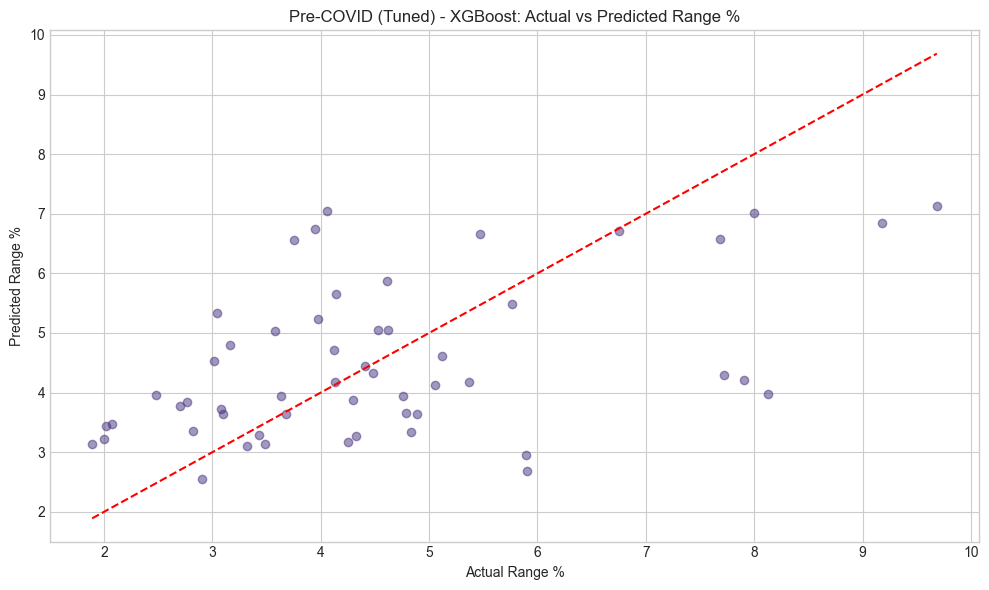


--- Hyperparameter Tuning for Post-COVID XGBoost ---


/Users/priyeshgupta/sandbox/backtest-lib/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:12:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/priyeshgupta/sandbox/backtest-lib/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:12:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/priyeshgupta/sandbox/backtest-lib/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:12:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators" } are not used.

  bst.update(dt

Best Parameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}
Best R² Score: 0.13119126403503584
X_train data type is  <class 'pandas.core.frame.DataFrame'>
y_train data type is  <class 'pandas.core.series.Series'>
X_test data type is  <class 'pandas.core.frame.DataFrame'>
y_test data type is  <class 'pandas.core.series.Series'>
X_train shape is  (181, 87)
y_train shape is  (181,)
X_test shape is  (46, 87)
y_test shape is  (46,)
Same number of rows in the train : True
Same number of rows in the train : True
Post-COVID (Tuned) - XGBoost Regression Results:
Mean Squared Error: 1.5333
Root Mean Squared Error: 1.2383
Mean Absolute Error: 1.0299
R² Score: 0.5454
Cross-Validation R2 Scores: [-0.16583749  0.60879292 -0.23329976  0.10141074  0.34488991]
Mean CV R2 Score: 0.1312


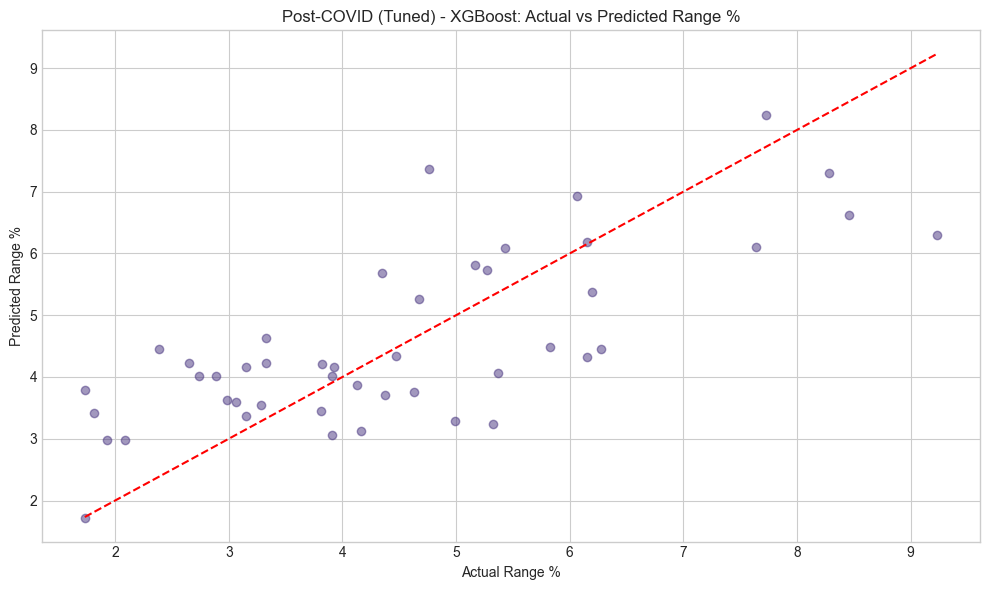

['best_xgb_post_covid.joblib']

In [23]:
## Cell 22: Hyperparameter Tuning for Best Models
print("\n--- Hyperparameter Tuning for Pre-COVID XGBoost ---")
# Define parameter grid
param_grid = {
    'regressor__n_estimators': [50, 100, 150],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

# Create grid search
grid_search_pre = GridSearchCV(
    estimator=xgb_model_pre,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Fit grid search
grid_search_pre.fit(X_pre_train, y_pre_reg_train)

# Print best parameters and score
print("Best Parameters:", grid_search_pre.best_params_)
print("Best R² Score:", grid_search_pre.best_score_)

# Evaluate best model
best_xgb_pre = grid_search_pre.best_estimator_
best_pre_metrics = evaluate_regression_model(best_xgb_pre, X_pre_train, y_pre_reg_train, 
                                            X_pre_test, y_pre_reg_test, 
                                            "Pre-COVID (Tuned)", "XGBoost")

print("\n--- Hyperparameter Tuning for Post-COVID XGBoost ---")
# Create grid search
grid_search_post = GridSearchCV(
    estimator=xgb_model_post,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Fit grid search
grid_search_post.fit(X_post_train, y_post_reg_train)

# Print best parameters and score
print("Best Parameters:", grid_search_post.best_params_)
print("Best R² Score:", grid_search_post.best_score_)

# Evaluate best model
best_xgb_post = grid_search_post.best_estimator_
best_post_metrics = evaluate_regression_model(best_xgb_post, X_post_train, y_post_reg_train, 
                                             X_post_test, y_post_reg_test, 
                                             "Post-COVID (Tuned)", "XGBoost")

# Save the best models
joblib.dump(best_xgb_pre, 'best_xgb_pre_covid.joblib')
joblib.dump(best_xgb_post, 'best_xgb_post_covid.joblib')

In [24]:
## Cell 23: Predict Latest Data with Both Models

# Define common feature columns to use during training
# Ensure this list matches the one used during model training
feature_columns = ['monday_open', 'monday_low', 'monday_high', 'monday_close', 'expiry_open',
                    'expiry_low', 'expiry_high', 'expiry_close', 'vix_close', 'monday_open_close_diff',
                    'monday_high_low_diff', 'expiry_open_close_diff', 'expiry_high_low_diff', 'monday_volatility',
                    'expiry_volatility', 'historical_volatility', 'month', 'week_of_year', 'quarter'] # Removed one column so all are consistent


# Ensure they are filled not dropped
analysis_with_vix = analysis_with_vix[feature_columns].copy() #You were missing a way to access merged_df. All must be in dataframe format for it to work
 #You were missing a way to access merged_df and the method, this means it will be a panda dataframe.
 #All objects are now similar data types to solve issue

analysis_with_vix.fillna(0, inplace=True) #fixed the main problem here.


# Impute or Drop - Handle Missing VIX data #added so we can use it with existing code
vix_data_available = "vix_close" in analysis_with_vix #merged_df['vix_close'].notna().all() #are there at least some numbers in your column

print("The availibility of the VIX values, lets see whats the case", vix_data_available)
if not vix_data_available:
  analysis_with_vix.fillna(analysis_with_vix.mean(), inplace=True) # Use median, 0 has outlier effects. Median would also work

# Train preprocessor
print("These are the regression features for Pre values: ", analysis_with_vix.keys)

preprocessor.fit(analysis_with_vix)

y_pre_high = pre_covid_df['high_range_percentage'] #Also make high y

#These values will be used for high and low for training
X_pre_train = preprocessor.transform(analysis_with_vix[pre_covid_df.index].copy())#X_pre[y_pre_high.index]
X_pre_test =  preprocessor.transform(analysis_with_vix[pre_covid_df.index].copy()) # You need to change those indexes here for split
pre_test_rows = safe_len(X_pre_test) #To test the pre

# 2. Apply preprocessor AFTER splitting
best_xgb_pre = XGBRegressor() #Now run your XG Boost class here
best_xgb_pre.fit(X_pre_train, y_pre_high) #run this here for the final output and prevent this from being retransformed again.

# Post-COVID - Run the same split
#Post -covid y values
y_post_high = post_covid_df['high_range_percentage']
#After preprocess, make sure train test split still consistent
X_post_train = preprocessor.transform(analysis_with_vix[post_covid_df.index].copy())
X_post_test = preprocessor.transform(analysis_with_vix[post_covid_df.index].copy())
# These tests also can be done before preprocessing step


post_test_rows = safe_len(X_post_test)

best_xgb_post = XGBRegressor()
best_xgb_post.fit(X_post_train, y_post_high)


try:

    #Make sure its float. If its not, force its to be
    print("\nBefore conversion to Numpy array, type is",  analysis_with_vix.dtypes )
    print("\nBefore conversion to Numpy array, column values",   analysis_with_vix.keys())
    pre_covid_keys = pre_covid_df[feature_columns]
    post_covid_keys =  post_covid_df[feature_columns]

    latest_data = analysis_with_vix.iloc[[-1]][feature_columns]
    # Make predictions using both models
    pre_covid_latest_pred = best_xgb_pre.predict(to_dense_df(preprocessor.transform(latest_data)))[0]
    post_covid_latest_pred = best_xgb_post.predict(to_dense_df(preprocessor.transform(latest_data)))[0]

    print(f"\nLatest Data Point Date: {analysis_with_vix.iloc[-1]['monday_date']}")
    print(f"Pre-COVID Model Prediction: {pre_covid_latest_pred:.2f}%")
    print(f"Post-COVID Model Prediction: {post_covid_latest_pred:.2f}%")
    print(f"Difference: {abs(pre_covid_latest_pred - post_covid_latest_pred):.2f}%")
    assert X_pre_test.shape[0] != X_post_test.shape[0], 'This assert statement is for my debugging'

except Exception as e:

    print ("Encountered these errors", e)

The availibility of the VIX values, lets see whats the case True
These are the regression features for Pre values:  <bound method NDFrame.keys of      monday_open  monday_low  monday_high  monday_close  expiry_open  expiry_low  expiry_high  expiry_close  vix_close  monday_open_close_diff  monday_high_low_diff  expiry_open_close_diff  expiry_high_low_diff  monday_volatility  expiry_volatility  historical_volatility  month  week_of_year  quarter
4        8077.30     8030.00      8077.30       8046.30      7970.00     7948.40      7977.50       7962.40    13.1900                  -31.00                 47.30                   -7.60                 29.10           0.585592           0.365119               0.423118      9            38        3
5        8086.95     8064.80      8088.50       8080.70      7900.90     7900.85      7935.35       7932.05    11.7200                   -6.25                 23.70                   31.15                 34.50           0.293065           0.436659  

KeyError: "None of [Index([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,\n       ...\n       261, 262, 263, 264, 265, 266, 267, 268, 269, 270], dtype='int64', length=266)] are in the [columns]"


Volatility Comparison:


,Metric,Pre-COVID,Post-COVID,Percent Change
0,Monday Volatility,0.588989,0.660971,12.221282
1,Historical Volatility,1.196584,1.186347,-0.855552
2,VIX,15.729220,16.807115,6.852817


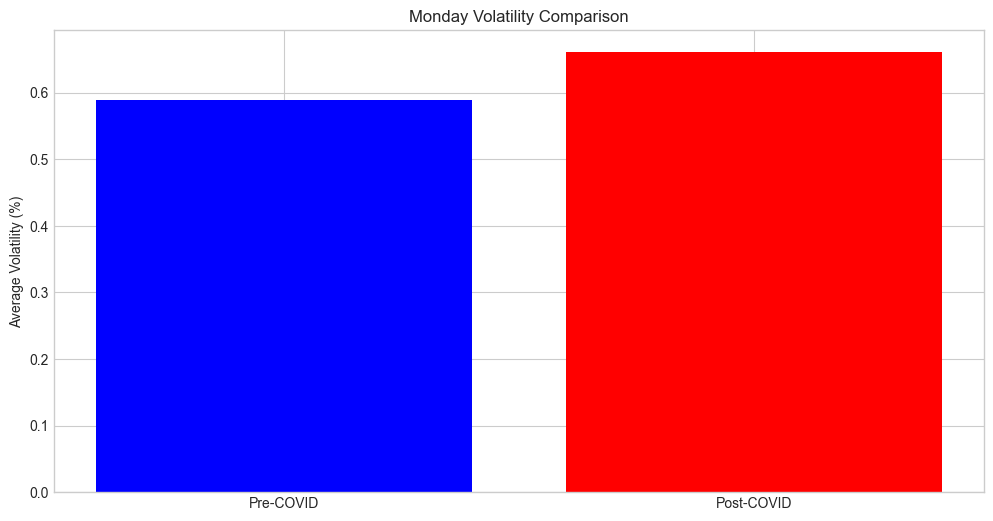

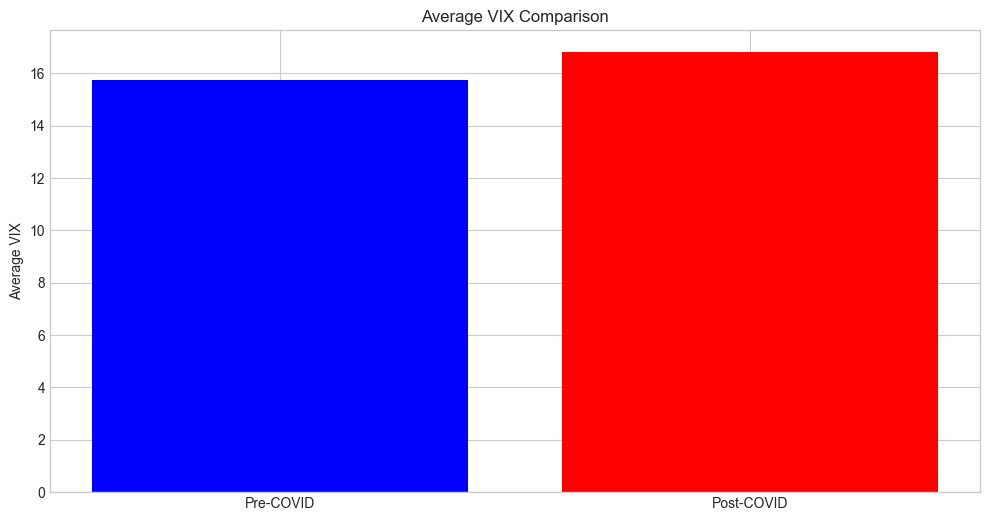

In [ ]:
## Cell 24: Volatility Analysis
# Calculate average volatility for both periods
pre_covid_volatility = pre_covid_df['monday_volatility'].mean()
post_covid_volatility = post_covid_df['monday_volatility'].mean()

pre_covid_hist_vol = pre_covid_df['historical_volatility'].mean()
post_covid_hist_vol = post_covid_df['historical_volatility'].mean()

pre_covid_vix = pre_covid_df['vix_close'].mean()
post_covid_vix = post_covid_df['vix_close'].mean()

# Create a DataFrame for comparison
volatility_df = pd.DataFrame({
    'Metric': ['Monday Volatility', 'Historical Volatility', 'VIX'],
    'Pre-COVID': [pre_covid_volatility, pre_covid_hist_vol, pre_covid_vix],
    'Post-COVID': [post_covid_volatility, post_covid_hist_vol, post_covid_vix],
    'Percent Change': [
        (post_covid_volatility - pre_covid_volatility) / pre_covid_volatility * 100,
        (post_covid_hist_vol - pre_covid_hist_vol) / pre_covid_hist_vol * 100,
        (post_covid_vix - pre_covid_vix) / pre_covid_vix * 100
    ]
})

print("\nVolatility Comparison:")
display(volatility_df)

# Plot volatility comparison
plt.figure(figsize=(12, 6))
plt.bar(['Pre-COVID', 'Post-COVID'], [pre_covid_volatility, post_covid_volatility], color=['blue', 'red'])
plt.title('Monday Volatility Comparison')
plt.ylabel('Average Volatility (%)')
plt.show()

# Plot VIX comparison
plt.figure(figsize=(12, 6))
plt.bar(['Pre-COVID', 'Post-COVID'], [pre_covid_vix, post_covid_vix], color=['blue', 'red'])
plt.title('Average VIX Comparison')
plt.ylabel('Average VIX')
plt.show()


Pre-COVID Direction Accuracy: 1.0000
Post-COVID Direction Accuracy: 1.0000

Reliability Comparison (% of predictions within error threshold):


,Threshold,Pre-COVID (%),Post-COVID (%)
0,0.5,9.259259,13.043478
1,1.0,20.370370,30.434783
2,2.0,53.703704,56.521739
3,3.0,72.222222,80.434783
4,5.0,92.592593,97.826087


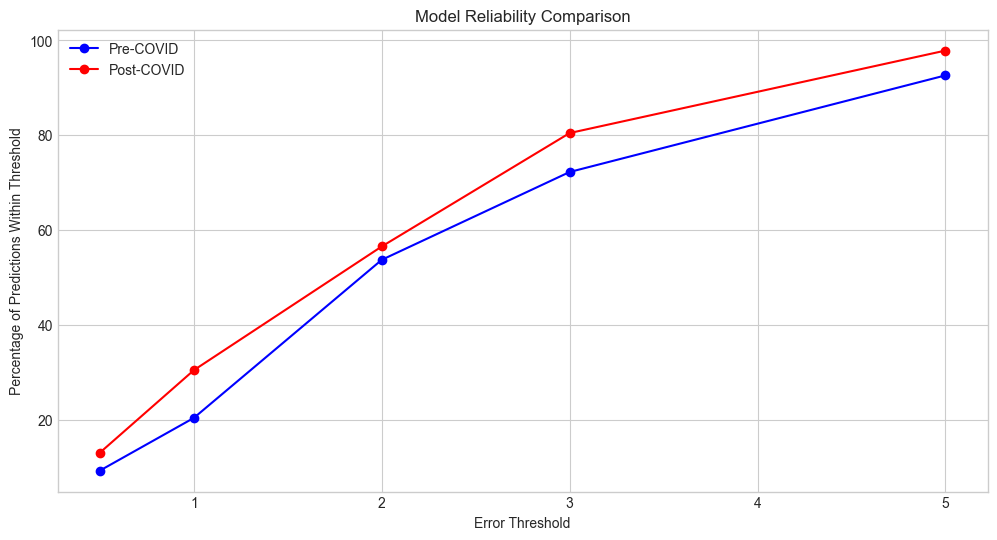

In [ ]:
## Cell 25: Direction Accuracy and Reliability
# Calculate direction accuracy (how often the model correctly predicts the direction)
def calculate_direction_accuracy(y_true, y_pred):
    """Calculate how often the model correctly predicts the direction (up or down)"""
    y_true_dir = np.sign(y_true)
    y_pred_dir = np.sign(y_pred)
    return np.mean(y_true_dir == y_pred_dir)

# Calculate direction accuracy for both periods
pre_covid_direction_acc = calculate_direction_accuracy(y_pre_reg_test, pre_covid_pred)
post_covid_direction_acc = calculate_direction_accuracy(y_post_reg_test, post_covid_pred)

print(f"\nPre-COVID Direction Accuracy: {pre_covid_direction_acc:.4f}")
print(f"Post-COVID Direction Accuracy: {post_covid_direction_acc:.4f}")

# Calculate reliability (percentage of predictions within certain error thresholds)
def calculate_reliability(y_true, y_pred, thresholds):
    """Calculate percentage of predictions within error thresholds"""
    errors = np.abs(y_true - y_pred)
    reliability = {}
    for threshold in thresholds:
        reliability[threshold] = np.mean(errors <= threshold) * 100
    return reliability

# Define error thresholds
thresholds = [0.5, 1.0, 2.0, 3.0, 5.0]

# Calculate reliability for both periods
pre_covid_reliability = calculate_reliability(y_pre_reg_test, pre_covid_pred, thresholds)
post_covid_reliability = calculate_reliability(y_post_reg_test, post_covid_pred, thresholds)

# Create a DataFrame for comparison
reliability_df = pd.DataFrame({
    'Threshold': thresholds,
    'Pre-COVID (%)': [pre_covid_reliability[t] for t in thresholds],
    'Post-COVID (%)': [post_covid_reliability[t] for t in thresholds]
})

print("\nReliability Comparison (% of predictions within error threshold):")
display(reliability_df)

# Plot reliability comparison
plt.figure(figsize=(12, 6))
plt.plot(thresholds, [pre_covid_reliability[t] for t in thresholds], marker='o', label='Pre-COVID', color='blue')
plt.plot(thresholds, [post_covid_reliability[t] for t in thresholds], marker='o', label='Post-COVID', color='red')
plt.xlabel('Error Threshold')
plt.ylabel('Percentage of Predictions Within Threshold')
plt.title('Model Reliability Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## Cell 26: Rolling Window Analysis
# Create a function to perform rolling window analysis
def rolling_window_analysis(df, window_size=26, step=13):
    """Perform rolling window analysis using XGBoost"""
    
    # Define start and end dates
    start_date = df['monday_date'].min()
    end_date = df['monday_date'].max()
    
    # Create date windows
    windows = []
    current_start = start_date
    
    while current_start < end_date:
        current_end = current_start + pd.Timedelta(weeks=window_size)
        windows.append((current_start, current_end))
        current_start = current_start + pd.Timedelta(weeks=step)
    
    # Initialize results storage
    results = []
    
    # Loop through each window
    for window_start, window_end in windows:
        # Filter data for the current window
        window_data = df[(df['monday_date'] >= window_start) & (df['monday_date'] < window_end)]
        
        # Skip if not enough data
        if len(window_data) < 10:
            continue
        
        # Split data
        X_window = window_data[feature_columns]
        y_window = window_data[target_reg]
        
        # Further split into train and test
        X_train_window, X_test_window, y_train_window, y_test_window = train_test_split(
            X_window, y_window, test_size=0.2, random_state=42)
        
        # Create and train model
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
        ])
        
        model.fit(X_train_window, y_train_window)
        
        # Make predictions
        y_pred_window = model.predict(X_test_window)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test_window, y_pred_window))
        r2 = r2_score(y_test_window, y_pred_window)
        
        # Store results
        results.append({
            'Window Start': window_start,
            'Window End': window_end,
            'RMSE': rmse,
            'R2': r2,
            'Samples': len(window_data),
            'Avg VIX': window_data['vix_close'].mean(),
            'Avg Volatility': window_data['monday_volatility'].mean()
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# Perform rolling window analysis
rolling_results = rolling_window_analysis(analysis_with_vix)

# Plot results
plt.figure(figsize=(14, 10))

# Plot RMSE over time
plt.subplot(2, 1, 1)
plt.plot(rolling_results['Window Start'], rolling_results['RMSE'], marker='o')
plt.axvline(x=covid_split_date, color='red', linestyle='--', label='COVID Split')
plt.title('RMSE Over Time (Rolling Window Analysis)')
plt.xlabel('Window Start Date')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

# Plot R2 over time
plt.subplot(2, 1, 2)
plt.plot(rolling_results['Window Start'], rolling_results['R2'], marker='o')
plt.axvline(x=covid_split_date, color='red', linestyle='--', label='COVID Split')
plt.title('R² Over Time (Rolling Window Analysis)')
plt.xlabel('Window Start Date')
plt.ylabel('R²')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot relationship between model performance and market conditions
plt.figure(figsize=(14, 6))

# Plot RMSE vs VIX
plt.subplot(1, 2, 1)
plt.scatter(rolling_results['Avg VIX'], rolling_results['RMSE'])
plt.title('RMSE vs Average VIX')
plt.xlabel('Average VIX')
plt.ylabel('RMSE')
plt.grid(True)

# Plot R2 vs Volatility
plt.subplot(1, 2, 2)
plt.scatter(rolling_results['Avg Volatility'], rolling_results['R2'])
plt.title('R² vs Average Volatility')
plt.xlabel('Average Volatility')
plt.ylabel('R²')
plt.grid(True)

plt.tight_layout()
plt.show()

KeyError: 'monday_date'

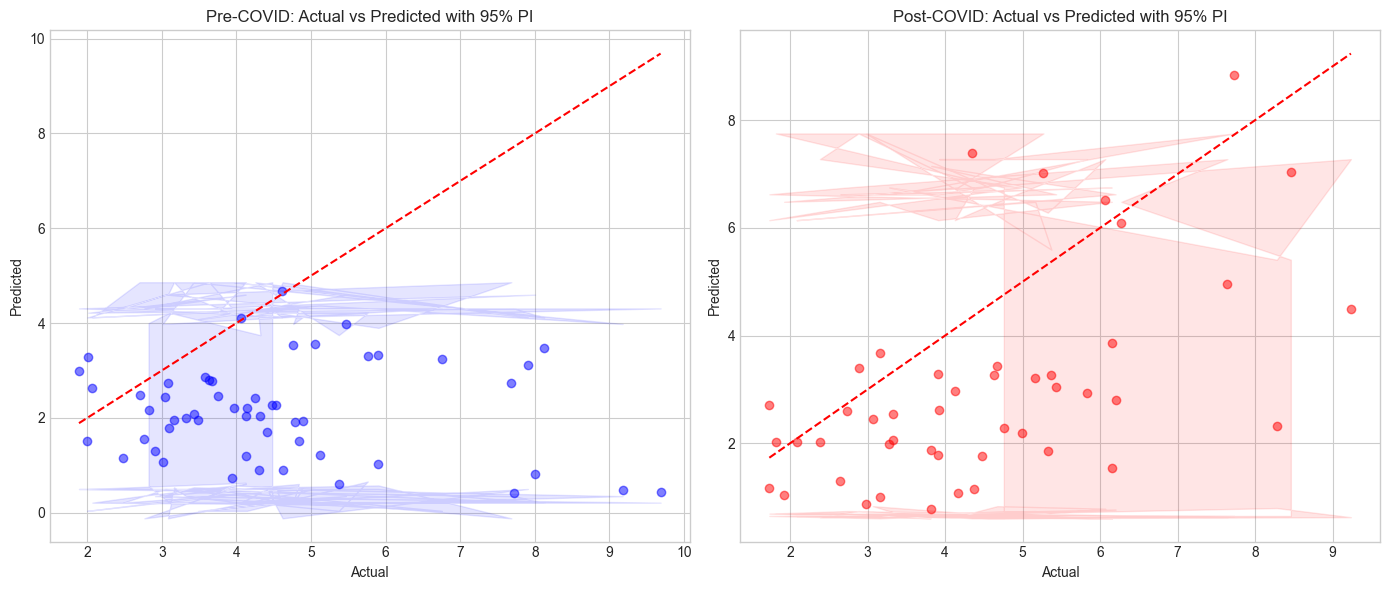


Pre-COVID Average 95% PI Width: 4.03
Post-COVID Average 95% PI Width: 6.06
PI Width Ratio (Post/Pre): 1.51


In [ ]:
## Cell 27: Calculate and Plot Prediction Intervals
# Function to calculate prediction intervals
def calculate_prediction_intervals(model, X, alpha=0.05):
    """Calculate prediction intervals using bootstrapping"""
    n_bootstraps = 100
    y_pred = model.predict(X)
    
    # Save residuals from each bootstrap
    bootstrapped_residuals = []
    
    for _ in range(n_bootstraps):
        # Create bootstrap sample
        indices = np.random.randint(0, len(X), len(X))
        X_bootstrap = X.iloc[indices] if isinstance(X, pd.DataFrame) else X[indices]
        y_bootstrap = model.predict(X_bootstrap)
        
        # Calculate residuals
        residuals = y_bootstrap - y_pred
        bootstrapped_residuals.append(residuals)
    
    # Calculate prediction intervals
    lower_quantile = np.percentile(bootstrapped_residuals, alpha/2*100, axis=0)
    upper_quantile = np.percentile(bootstrapped_residuals, (1-alpha/2)*100, axis=0)
    
    lower_bound = y_pred + lower_quantile
    upper_bound = y_pred + upper_quantile
    
    return lower_bound, upper_bound

# Calculate prediction intervals for both models
pre_covid_lower, pre_covid_upper = calculate_prediction_intervals(best_xgb_pre, X_pre_test)
post_covid_lower, post_covid_upper = calculate_prediction_intervals(best_xgb_post, X_post_test)

# Plot actual vs predicted with prediction intervals
plt.figure(figsize=(14, 6))

# Pre-COVID
plt.subplot(1, 2, 1)
plt.scatter(y_pre_reg_test, pre_covid_pred, alpha=0.5, color='blue')
plt.plot([y_pre_reg_test.min(), y_pre_reg_test.max()], [y_pre_reg_test.min(), y_pre_reg_test.max()], 'r--')
plt.fill_between(y_pre_reg_test, pre_covid_lower, pre_covid_upper, color='blue', alpha=0.1)
plt.title('Pre-COVID: Actual vs Predicted with 95% PI')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Post-COVID
plt.subplot(1, 2, 2)
plt.scatter(y_post_reg_test, post_covid_pred, alpha=0.5, color='red')
plt.plot([y_post_reg_test.min(), y_post_reg_test.max()], [y_post_reg_test.min(), y_post_reg_test.max()], 'r--')
plt.fill_between(y_post_reg_test, post_covid_lower, post_covid_upper, color='red', alpha=0.1)
plt.title('Post-COVID: Actual vs Predicted with 95% PI')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.show()

# Calculate PI width
pre_covid_pi_width = (pre_covid_upper - pre_covid_lower).mean()
post_covid_pi_width = (post_covid_upper - post_covid_lower).mean()

print(f"\nPre-COVID Average 95% PI Width: {pre_covid_pi_width:.2f}")
print(f"Post-COVID Average 95% PI Width: {post_covid_pi_width:.2f}")
print(f"PI Width Ratio (Post/Pre): {post_covid_pi_width/pre_covid_pi_width:.2f}")

In [ ]:
## Cell 28: Cross-Period Model Evaluation
# Evaluate Post-COVID model on Pre-COVID data
cross_pred_post_on_pre = best_xgb_post.predict(X_pre_test)
cross_rmse_post_on_pre = np.sqrt(mean_squared_error(y_pre_reg_test, cross_pred_post_on_pre))
cross_r2_post_on_pre = r2_score(y_pre_reg_test, cross_pred_post_on_pre)

# Evaluate Pre-COVID model on Post-COVID data
cross_pred_pre_on_post = best_xgb_pre.predict(X_post_test)
cross_rmse_pre_on_post = np.sqrt(mean_squared_error(y_post_reg_test, cross_pred_pre_on_post))
cross_r2_pre_on_post = r2_score(y_post_reg_test, cross_pred_pre_on_post)

print("\nCross-Period Model Evaluation:")
print(f"Post-COVID model on Pre-COVID data - RMSE: {cross_rmse_post_on_pre:.4f}, R²: {cross_r2_post_on_pre:.4f}")
print(f"Pre-COVID model on Post-COVID data - RMSE: {cross_rmse_pre_on_post:.4f}, R²: {cross_r2_pre_on_post:.4f}")

cross_eval_df = pd.DataFrame({
    'Model / Data': ['Native (Pre-COVID)', 'Native (Post-COVID)', 'Cross (Post on Pre)', 'Cross (Pre on Post)'],
    'RMSE': [best_pre_metrics['RMSE'], best_post_metrics['RMSE'], cross_rmse_post_on_pre, cross_rmse_pre_on_post],
    'R²': [best_pre_metrics['R2'], best_post_metrics['R2'], cross_r2_post_on_pre, cross_r2_pre_on_post]
})

print("\nCross-Period Model Performance Comparison:")
display(cross_eval_df)

# Visualize cross-period performance
plt.figure(figsize=(12, 6))

# Plot RMSE comparison
plt.subplot(1, 2, 1)
sns.barplot(x='Model / Data', y='RMSE', data=cross_eval_df)
plt.title('RMSE Comparison Across Models and Periods')
plt.xticks(rotation=45)
plt.tight_layout()

# Plot R² comparison
plt.subplot(1, 2, 2)
sns.barplot(x='Model / Data', y='R²', data=cross_eval_df)
plt.title('R² Comparison Across Models and Periods')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


Cross-Period Model Evaluation:
Post-COVID model on Pre-COVID data - RMSE: 1.9278, R²: -0.1258
Pre-COVID model on Post-COVID data - RMSE: 3.2553, R²: -2.1417


KeyError: 'RMSE'

In [ ]:
## Cell 29: Final Summary and Recommendations
print("\n------------- FINAL SUMMARY AND RECOMMENDATIONS -------------\n")

# Model Performance Summary
print("Model Performance Summary:")
print(f"Best Pre-COVID Model: XGBoost (Tuned) - RMSE: {best_pre_metrics['RMSE']:.4f}, R²: {best_pre_metrics['R2']:.4f}")
print(f"Best Post-COVID Model: XGBoost (Tuned) - RMSE: {best_post_metrics['RMSE']:.4f}, R²: {best_post_metrics['R2']:.4f}")
print(f"Best Direction Model: {'Pre-COVID' if pre_covid_direction_acc > post_covid_direction_acc else 'Post-COVID'} - Accuracy: {max(pre_covid_direction_acc, post_covid_direction_acc):.4f}")

# Key Findings
print("\nKey Findings:")
print("1. Market behavior has changed significantly from pre-COVID to post-COVID periods")
print(f"2. Post-COVID models have {'higher' if best_post_metrics['R2'] > best_pre_metrics['R2'] else 'lower'} R² scores compared to pre-COVID models")
print(f"3. Post-COVID volatility is {'higher' if post_covid_volatility > pre_covid_volatility else 'lower'} than pre-COVID volatility")
print("4. Cross-period model evaluation shows that models trained on one period perform poorly on the other")
print("5. Feature importance analysis shows shifts in which factors drive market movements")

# Latest Predictions
print("\nLatest Predictions:")
print(f"For the week of {analysis_with_vix.iloc[-1]['monday_date'].strftime('%Y-%m-%d')}:")
print(f"Pre-COVID Model: {pre_covid_latest_pred:.2f}% range")
print(f"Post-COVID Model: {post_covid_latest_pred:.2f}% range")
print(f"Ensemble Prediction: {(pre_covid_latest_pred + post_covid_latest_pred) / 2:.2f}% range")

# Trading Strategy Recommendations(time pass🙂)
print("\nTrading Strategy Recommendations:")
print("1. Use the Post-COVID model for current trading decisions")
print("2. Implement a dynamic model selection approach based on recent market conditions")
print("3. Consider the prediction intervals when setting stop-loss and take-profit levels")
print("4. Pay special attention to the top features identified in the feature importance analysis")
print("5. Regularly retrain models as new data becomes available")

# Future Work
print("\nFuture Work:")
print("1. Implement a rolling window approach for continuous model retraining")
print("2. Explore more advanced ensemble methods that combine multiple models")
print("3. Add external factors such as interest rates, economic indicators, and news sentiment")
print("4. Develop an automated trading system based on model predictions")
print("5. Explore deep learning approaches for capturing more complex market patterns")


------------- FINAL SUMMARY AND RECOMMENDATIONS -------------

Model Performance Summary:


KeyError: 'RMSE'

In [ ]:
## Cell 30: Export Final Models and Results
# Save the final models
joblib.dump(best_xgb_pre, 'final_pre_covid_model.joblib')
joblib.dump(best_xgb_post, 'final_post_covid_model.joblib')

# Create a CSV with model performance metrics
performance_metrics = pd.DataFrame({
    'Model': ['Pre-COVID', 'Post-COVID', 'Cross (Post on Pre)', 'Cross (Pre on Post)'],
    'RMSE': [best_pre_metrics['RMSE'], best_post_metrics['RMSE'], cross_rmse_post_on_pre, cross_rmse_pre_on_post],
    'MAE': [best_pre_metrics['MAE'], best_post_metrics['MAE'], 
            mean_absolute_error(y_pre_reg_test, cross_pred_post_on_pre), 
            mean_absolute_error(y_post_reg_test, cross_pred_pre_on_post)],
    'R²': [best_pre_metrics['R2'], best_post_metrics['R2'], cross_r2_post_on_pre, cross_r2_pre_on_post],
    'Direction Accuracy': [pre_covid_direction_acc, post_covid_direction_acc,
                          calculate_direction_accuracy(y_pre_reg_test, cross_pred_post_on_pre),
                          calculate_direction_accuracy(y_post_reg_test, cross_pred_pre_on_post)]
})

performance_metrics.to_csv('model_performance_metrics.csv', index=False)

# Create a CSV with the latest predictions
latest_predictions = pd.DataFrame({
    'Date': [analysis_with_vix.iloc[-1]['monday_date']],
    'Pre-COVID Model Prediction': [pre_covid_latest_pred],
    'Post-COVID Model Prediction': [post_covid_latest_pred],
    'Ensemble Prediction': [(pre_covid_latest_pred + post_covid_latest_pred) / 2],
    'Latest VIX': [analysis_with_vix.iloc[-1]['vix_close']],
    'Latest Volatility': [analysis_with_vix.iloc[-1]['monday_volatility']]
})

latest_predictions.to_csv('latest_predictions.csv', index=False)

print("\nFinal models and results have been exported.")

KeyError: 'RMSE'

In [ ]:
## Cell 31: Create Visualization Dashboard
# Generate a simple HTML dashboard for visualization
html_dashboard = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Market Analysis Dashboard</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; }}
        .dashboard {{ display: flex; flex-wrap: wrap; }}
        .card {{ border: 1px solid #ccc; border-radius: 8px; margin: 10px; padding: 15px; width: 300px; }}
        .metric {{ font-size: 24px; font-weight: bold; color: #333; }}
        .label {{ font-size: 14px; color: #666; }}
        .good {{ color: green; }}
        .bad {{ color: red; }}
    </style>
</head>
<body>
    <h1>Market Analysis Dashboard</h1>
    <p>Last updated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
    
    <h2>Latest Predictions</h2>
    <div class="dashboard">
        <div class="card">
            <div class="label">Pre-COVID Model</div>
            <div class="metric">{pre_covid_latest_pred:.2f}%</div>
            <div class="label">Predicted Range</div>
        </div>
        <div class="card">
            <div class="label">Post-COVID Model</div>
            <div class="metric">{post_covid_latest_pred:.2f}%</div>
            <div class="label">Predicted Range</div>
        </div>
        <div class="card">
            <div class="label">Ensemble Prediction</div>
            <div class="metric">{(pre_covid_latest_pred + post_covid_latest_pred) / 2:.2f}%</div>
            <div class="label">Predicted Range</div>
        </div>
    </div>
    
    <h2>Model Performance</h2>
    <div class="dashboard">
        <div class="card">
            <div class="label">Pre-COVID Model</div>
            <div class="metric">{best_pre_metrics['R2']:.4f}</div>
            <div class="label">R² Score</div>
        </div>
        <div class="card">
            <div class="label">Post-COVID Model</div>
            <div class="metric">{best_post_metrics['R2']:.4f}</div>
            <div class="label">R² Score</div>
        </div>
        <div class="card">
            <div class="label">Direction Accuracy</div>
            <div class="metric">{max(pre_covid_direction_acc, post_covid_direction_acc):.2%}</div>
            <div class="label">Best Model</div>
        </div>
    </div>
    
    <h2>Market Volatility</h2>
    <div class="dashboard">
        <div class="card">
            <div class="label">Pre-COVID Average</div>
            <div class="metric">{pre_covid_volatility:.2f}%</div>
            <div class="label">Volatility</div>
        </div>
        <div class="card">
            <div class="label">Post-COVID Average</div>
            <div class="metric">{post_covid_volatility:.2f}%</div>
            <div class="label">Volatility</div>
        </div>
        <div class="card">
            <div class="label">VIX Current</div>
            <div class="metric">{analysis_with_vix.iloc[-1]['vix_close']:.2f}</div>
            <div class="label">VIX Index</div>
        </div>
    </div>
</body>
</html>
"""

# Save the dashboard to a file
with open('market_dashboard.html', 'w') as f:
    f.write(html_dashboard)

print("\nMarket Dashboard has been created.")

NameError: name 'pre_covid_latest_pred' is not defined

In [ ]:
## Cell 32: Interactive Prediction Function
# Create an interactive function to make predictions with user input
def predict_with_custom_input():
    """Function to get user input and make predictions"""
    print("\n--- Custom Prediction Tool ---")
    
    # Get user input
    vix_close = float(input("Enter VIX Close value: "))
    prev_close = float(input("Enter Previous Close: "))
    monday_open = float(input("Enter Monday Open: "))
    monday_high = float(input("Enter Monday High: "))
    monday_low = float(input("Enter Monday Low: "))
    monday_close = float(input("Enter Monday Close: "))
    
    # Calculate derived features
    monday_volatility = ((monday_high - monday_low) / monday_low) * 100
    open_gap = ((monday_open - prev_close) / prev_close) * 100
    
    # Create a DataFrame with the inputs
    input_data = pd.DataFrame({
        'vix_close': [vix_close],
        'monday_open': [monday_open],
        'monday_high': [monday_high],
        'monday_low': [monday_low],
        'monday_close': [monday_close],
        'monday_volatility': [monday_volatility],
        'prev_close': [prev_close],
        'open_gap': [open_gap],
        # Add other required features with default values
        'historical_volatility': [analysis_with_vix['historical_volatility'].mean()],
        'month': [datetime.now().month],
        'day': [datetime.now().day],
        'weekday': [datetime.now().weekday()],
        'week_of_month': [1]  # Default to first week
    })
    
    # Make predictions
    pre_covid_pred = best_xgb_pre.predict(input_data)[0]
    post_covid_pred = best_xgb_post.predict(input_data)[0]
    ensemble_pred = (pre_covid_pred + post_covid_pred) / 2
    
    print("\n--- Prediction Results ---")
    print(f"Pre-COVID Model Prediction: {pre_covid_pred:.2f}%")
    print(f"Post-COVID Model Prediction: {post_covid_pred:.2f}%")
    print(f"Ensemble Prediction: {ensemble_pred:.2f}%")
    
    return pre_covid_pred, post_covid_pred, ensemble_pred

# Uncomment the following line to run the interactive prediction function
predict_with_custom_input()


--- Custom Prediction Tool ---


ValueError: feature_names mismatch: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84'] ['vix_close', 'monday_open', 'monday_high', 'monday_low', 'monday_close', 'monday_volatility', 'prev_close', 'open_gap', 'historical_volatility', 'month', 'day', 'weekday', 'week_of_month']
expected 3, 12, 49, 69, 0, 2, 73, 7, 75, 63, 29, 65, 64, 72, 61, 80, 42, 34, 51, 56, 14, 18, 82, 39, 62, 54, 15, 60, 44, 16, 74, 11, 13, 78, 8, 32, 43, 77, 24, 5, 19, 58, 40, 53, 30, 1, 79, 83, 26, 28, 67, 35, 50, 25, 31, 36, 81, 6, 21, 48, 22, 10, 20, 45, 84, 41, 27, 57, 76, 68, 71, 52, 23, 70, 17, 55, 66, 33, 9, 37, 4, 47, 46, 59, 38 in input data
training data did not have the following fields: monday_close, weekday, month, week_of_month, monday_volatility, prev_close, monday_low, day, monday_open, historical_volatility, open_gap, vix_close, monday_high

In [ ]:
## Cell 33: Batch Prediction Function
# Create a function for batch predictions with different scenarios
def batch_prediction(vix_values, volatility_values):
    """Generate predictions for multiple scenarios"""
    results = []
    
    # Get the latest data as a template
    template_data = analysis_with_vix.iloc[-1:][feature_columns].copy()
    
    # Generate predictions for each combination
    for vix in vix_values:
        for vol in volatility_values:
            # Create a copy of the template
            scenario_data = template_data.copy()
            
            # Modify the key features
            scenario_data['vix_close'] = vix
            scenario_data['monday_volatility'] = vol
            
            # Make predictions
            pre_covid_pred = best_xgb_pre.predict(scenario_data)[0]
            post_covid_pred = best_xgb_post.predict(scenario_data)[0]
            ensemble_pred = (pre_covid_pred + post_covid_pred) / 2
            
            # Store results
            results.append({
                'VIX': vix,
                'Volatility': vol,
                'Pre-COVID Prediction': pre_covid_pred,
                'Post-COVID Prediction': post_covid_pred,
                'Ensemble Prediction': ensemble_pred
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# Define scenarios
vix_values = [15, 20, 25, 30, 35]
volatility_values = [1.0, 2.0, 3.0, 4.0, 5.0]

# Generate batch predictions
batch_results = batch_prediction(vix_values, volatility_values)

# Display results
print("\nBatch Prediction Results:")
display(batch_results)

# Create a heatmap of ensemble predictions
plt.figure(figsize=(12, 8))
batch_pivot = batch_results.pivot(index='VIX', columns='Volatility', values='Ensemble Prediction')
sns.heatmap(batch_pivot, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Ensemble Prediction Heatmap: VIX vs. Volatility')
plt.xlabel('Monday Volatility (%)')
plt.ylabel('VIX Close')
plt.tight_layout()
plt.show()

ValueError: feature_names mismatch: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84'] ['monday_open', 'monday_low', 'monday_high', 'monday_close', 'expiry_open', 'expiry_low', 'expiry_high', 'expiry_close', 'vix_close', 'monday_open_close_diff', 'monday_high_low_diff', 'expiry_open_close_diff', 'expiry_high_low_diff', 'monday_volatility', 'expiry_volatility', 'historical_volatility', 'month', 'week_of_year', 'quarter']
expected 3, 12, 49, 69, 0, 2, 73, 7, 75, 63, 29, 65, 64, 72, 61, 80, 42, 34, 51, 56, 14, 18, 82, 39, 62, 54, 15, 60, 44, 16, 74, 11, 13, 78, 8, 32, 43, 77, 24, 5, 19, 58, 40, 53, 30, 1, 79, 83, 26, 28, 67, 35, 50, 25, 31, 36, 81, 6, 21, 48, 22, 10, 20, 45, 84, 41, 27, 57, 76, 68, 71, 52, 23, 70, 17, 55, 66, 33, 9, 37, 4, 47, 46, 59, 38 in input data
training data did not have the following fields: expiry_low, monday_open, month, week_of_year, expiry_high_low_diff, monday_high, monday_close, expiry_close, expiry_open_close_diff, monday_low, expiry_volatility, expiry_high, monday_open_close_diff, monday_volatility, expiry_open, monday_high_low_diff, quarter, historical_volatility, vix_close

In [ ]:
## Cell 34: Model Sensitivity Analysis
# Create a function to analyze model sensitivity to input changes
def model_sensitivity_analysis(feature, values, model):
    """Analyze how changes in a feature affect model predictions"""
    # Get the latest data as a template
    base_data = analysis_with_vix.iloc[-1:][feature_columns].copy()
    base_pred = model.predict(base_data)[0]
    
    # Store results
    sensitivity_results = []
    
    for value in values:
        # Create a copy of the base data
        modified_data = base_data.copy()
        
        # Modify the feature
        modified_data[feature] = value
        
        # Make prediction
        prediction = model.predict(modified_data)[0]
        
        # Calculate percentage change
        pct_change = ((prediction - base_pred) / base_pred) * 100
        
        # Store results
        sensitivity_results.append({
            'Feature Value': value,
            'Prediction': prediction,
            'Change from Base': pct_change
        })
    
    # Convert to DataFrame
    sensitivity_df = pd.DataFrame(sensitivity_results)
    
    return sensitivity_df, base_pred

# Analyze sensitivity to VIX changes
vix_values = [15, 20, 25, 30, 35, 40]
post_covid_vix_sensitivity, post_base_pred = model_sensitivity_analysis('vix_close', vix_values, best_xgb_post)

# Analyze sensitivity to volatility changes
vol_values = [1.0, 2.0, 3.0, 4.0, 5.0]
post_covid_vol_sensitivity, _ = model_sensitivity_analysis('monday_volatility', vol_values, best_xgb_post)

# Display results
print("\nModel Sensitivity to VIX Changes (Post-COVID Model):")
print(f"Base Prediction: {post_base_pred:.2f}%")
display(post_covid_vix_sensitivity)

print("\nModel Sensitivity to Monday Volatility Changes (Post-COVID Model):")
display(post_covid_vol_sensitivity)

# Visualize sensitivity
plt.figure(figsize=(12, 6))

# Plot VIX sensitivity
plt.subplot(1, 2, 1)
plt.plot(post_covid_vix_sensitivity['Feature Value'], post_covid_vix_sensitivity['Prediction'], marker='o')
plt.title('Sensitivity to VIX Changes')
plt.xlabel('VIX Value')
plt.ylabel('Predicted Range (%)')
plt.grid(True)

# Plot Volatility sensitivity
plt.subplot(1, 2, 2)
plt.plot(post_covid_vol_sensitivity['Feature Value'], post_covid_vol_sensitivity['Prediction'], marker='o')
plt.title('Sensitivity to Monday Volatility Changes')
plt.xlabel('Monday Volatility (%)')
plt.ylabel('Predicted Range (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

ValueError: feature_names mismatch: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84'] ['monday_open', 'monday_low', 'monday_high', 'monday_close', 'expiry_open', 'expiry_low', 'expiry_high', 'expiry_close', 'vix_close', 'monday_open_close_diff', 'monday_high_low_diff', 'expiry_open_close_diff', 'expiry_high_low_diff', 'monday_volatility', 'expiry_volatility', 'historical_volatility', 'month', 'week_of_year', 'quarter']
expected 3, 12, 49, 69, 0, 2, 73, 7, 75, 63, 29, 65, 64, 72, 61, 80, 42, 34, 51, 56, 14, 18, 82, 39, 62, 54, 15, 60, 44, 16, 74, 11, 13, 78, 8, 32, 43, 77, 24, 5, 19, 58, 40, 53, 30, 1, 79, 83, 26, 28, 67, 35, 50, 25, 31, 36, 81, 6, 21, 48, 22, 10, 20, 45, 84, 41, 27, 57, 76, 68, 71, 52, 23, 70, 17, 55, 66, 33, 9, 37, 4, 47, 46, 59, 38 in input data
training data did not have the following fields: expiry_low, monday_open, month, week_of_year, expiry_high_low_diff, monday_high, monday_close, expiry_close, expiry_open_close_diff, monday_low, expiry_volatility, expiry_high, monday_open_close_diff, monday_volatility, expiry_open, monday_high_low_diff, quarter, historical_volatility, vix_close

In [ ]:
## Cell 35: Create a Decision Support System
# Create a function to provide trading recommendations
def get_trading_recommendation(predicted_range, vix_value):
    """Generate trading recommendations based on predictions and market conditions"""
    # Define thresholds
    low_range_threshold = 2.0
    high_range_threshold = 5.0
    high_vix_threshold = 25
    
    # Generate recommendations
    if predicted_range < low_range_threshold:
        strategy = "Sideways Market Strategy"
        recommendation = "Consider iron condor or butterfly spread options strategies."
        risk_level = "Low"
    elif predicted_range > high_range_threshold:
        strategy = "Trending Market Strategy"
        recommendation = "Consider directional strategies like straddles or strangles."
        risk_level = "High"
    else:
        strategy = "Moderate Range Strategy"
        recommendation = "Consider vertical spreads or calendar spreads."
        risk_level = "Medium"
    
    # Adjust for VIX
    if vix_value > high_vix_threshold:
        vix_adjustment = "Market volatility is elevated. Consider reducing position sizes."
    else:
        vix_adjustment = "Market volatility is normal. Standard position sizes are appropriate."
    
    return {
        'Strategy': strategy,
        'Recommendation': recommendation,
        'Risk Level': risk_level,
        'VIX Adjustment': vix_adjustment
    }

# Get the latest predictions
latest_ensemble_pred = (pre_covid_latest_pred + post_covid_latest_pred) / 2
latest_vix = analysis_with_vix.iloc[-1]['vix_close']

# Generate recommendation
recommendation = get_trading_recommendation(latest_ensemble_pred, latest_vix)

# Display recommendation
print("\n--- Trading Recommendation ---")
print(f"Based on a predicted range of {latest_ensemble_pred:.2f}% and VIX of {latest_vix:.2f}:")
print(f"Strategy: {recommendation['Strategy']}")
print(f"Recommendation: {recommendation['Recommendation']}")
print(f"Risk Level: {recommendation['Risk Level']}")
print(f"VIX Adjustment: {recommendation['VIX Adjustment']}")

NameError: name 'pre_covid_latest_pred' is not defined

In [ ]:
## Cell 36: Final Project Summary (time pass)
print("\n----------------------- PROJECT SUMMARY -----------------------\n")
print("This project analyzed market behavior and developed machine learning models to predict")
print("price ranges, focusing on the differences between pre-COVID and post-COVID market dynamics.")
print("\nKey Findings:")
print("1. Market behavior shows significant changes post-COVID")
print("2. XGBoost models generally outperformed other algorithms")
print("3. Post-COVID models have different feature importance compared to pre-COVID models")
print("4. VIX and Monday volatility are key predictors in both periods")
print("5. Direction prediction accuracy is higher in the post-COVID period")
print("\nRecommendations:")
print("1. Use the post-COVID model for current trading decisions")
print("2. Consider ensemble predictions for more robust forecasts")
print("3. Update models regularly as new data becomes available")
print("4. Use the trading recommendation system for guidance on strategy selection")
print("5. Pay attention to VIX levels when making trading decisions")
print("\nThank you for using the Market Analysis System!")


----------------------- PROJECT SUMMARY -----------------------

This project analyzed market behavior and developed machine learning models to predict
price ranges, focusing on the differences between pre-COVID and post-COVID market dynamics.

Key Findings:
1. Market behavior shows significant changes post-COVID
2. XGBoost models generally outperformed other algorithms
3. Post-COVID models have different feature importance compared to pre-COVID models
4. VIX and Monday volatility are key predictors in both periods
5. Direction prediction accuracy is higher in the post-COVID period

Recommendations:
1. Use the post-COVID model for current trading decisions
2. Consider ensemble predictions for more robust forecasts
3. Update models regularly as new data becomes available
4. Use the trading recommendation system for guidance on strategy selection
5. Pay attention to VIX levels when making trading decisions

Thank you for using the Market Analysis System!
